# All the Imports

In [1]:
import os
from os import path
import logging

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
path="/content/gdrive/MyDrive/Colab Notebooks/MarkerMap0/MarkerMap"
os.chdir(path)
os.listdir(path)

Mounted at /content/gdrive


['notebooks',
 'data',
 'setup.cfg',
 'marker_map.png',
 '.pre-commit-config.yaml',
 '.gitignore',
 'pyproject.toml',
 'LICENSE',
 'tests',
 'src',
 'dist',
 '.git',
 'scripts',
 'Figures',
 'weights',
 '=',
 'README.md']

In [ ]:
!pip install lassonet==0.0.9
!pip install smashpy
!pip install markermap
!pip install scikit-learn

In [ ]:
!python -m pip install lassonet==0.0.9
!python -m pip install pytorch-lightning
!python -m pip install scanpy
!python -m pip install seaborn
!python -m pip install smashpy
!python -m pip install umap-learn
!python -m pip install scikit-learn
!python -m pip install typing-extensions --upgrade
!python -m pip install matplotlib==3.1.3
!python -m pip install scprep

In [ ]:
os.kill(os.getpid(), 9)

In [2]:
import itertools 
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os import path
from sklearn.preprocessing import LabelEncoder
from lassonet import LassoNetClassifier

import smashpy as smashpy

import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

from markermap.other_models import RankCorrWrapper, SmashPyWrapper
from markermap.vae_models import MarkerMap, ConcreteVAE_NMSL, VAE_Gumbel_GlobalGate, VAE_l1_diag, train_save_model
from markermap.utils import (
    get_citeseq,
    model_variances,
    new_model_metrics, 
    plot_confusion_matrix,
    plot_umap_embedding, 
    split_data_into_dataloaders, 
)

CPU times: user 14.7 s, sys: 1.61 s, total: 16.3 s
Wall time: 25.7 s


In [3]:
logging.getLogger("lightning").setLevel(logging.ERROR)
pl_loggers = [ logging.getLogger(name) for name in logging.root.manager.loggerDict if 'lightning' in name ]

for logger in pl_loggers:
    logger.setLevel(logging.ERROR)
    
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# These should be parameters later on 

In [4]:
z_size = 16
hidden_layer_size = 64

# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
batch_size = 64
batch_norm = True


global_t = 3.0

k_range = [10, 25, 50, 100, 250]
num_times = 10
k = 50
gpus = None
tpu_cores = None
precision = 32

# The smashpy methods set global seeds that mess with sampling. These seeds are used 
# to stop those methods from using the same global seed over and over.
possible_seeds = np.random.randint(low=1, high = 1000000, size = 400)
seed_index = 0

In [5]:
import multiprocessing

num_cores = multiprocessing.cpu_count()

# Here goes all the stuff that we change from dataset to dataset

In [ ]:
!ls

data  Figures  marker_map.png  pyproject.toml  scripts	  src	 weights
dist  LICENSE  notebooks       README.md       setup.cfg  tests


In [6]:
dataset_dir = './data/cite_seq/'
model_save_path = './data/CITE-seq/models/'
viz_save_path = './data/CITE-seq/visualizations/'

if not path.exists(model_save_path):
  os.makedirs(model_save_path)

if not path.exists(model_save_path + 'experiment_data_folds/'):
  os.makedirs(model_save_path + 'experiment_data_folds/')
  
if not path.exists(viz_save_path):
  os.makedirs(viz_save_path)

  

# Dataset Specific Processing

In [7]:
import numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import LabelEncoder


def _get_citeseq(CITEseq_mat_file_path, CITEseq_names_file_path):
    """
    Replacement of `get_citeseq` for loading `CITEseq.mat` and `CITEseq-names.mat` with same return value as original function.
    `CITEseq.mat` contains the raw scRNA-seq counts.
    `CITEseq-names.mat` contains the names (string labels) of the cells.

    Author: Jifeng Wu

    :param str CITEseq_mat_file_path: The file path of `CITEseq.mat`
    :param str CITEseq_names_file_path: The file path of `CITEseq-names.mat`
    """
    CITEseq_mat = loadmat(CITEseq_mat_file_path)
    CITEseq_names = loadmat(CITEseq_names_file_path)
    
    # Get the scRNA-seq count matrix, with each row being a cell and each column being a gene.
    X = CITEseq_mat['G'].T.astype(np.float32)
    
    # Get the names (string labels) of the cells.
    names = np.array([ element[0][0] for element in CITEseq_names['citeseq_names'] ])
    
    # Create a `LabelEncoder` and fit `names`.
    encoder = LabelEncoder()
    encoder.fit(names)
    
    # Generate the numerical labels.
    y = encoder.transform(names)
    
    # Same return value as original function.
    return X, y, encoder

In [8]:
# X, y, encoder = get_citeseq(dataset_dir + "CITEseq.h5ad")
X, y, encoder = _get_citeseq('./data/CITEseq/CITEseq.mat', './data/CITEseq/CITEseq_names.mat')
input_size = X.shape[1]

In [16]:
X.shape

(8617, 500)

# Set Up Models

Training here will differ than in other notebooks.

Training multiple times at k = 50

Also training one trial at k's ranging from 10 to 250.

## All Markers

In [ ]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    all_markers = np.arange(X.shape[1])
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = all_markers)
    np.save(model_save_path + 'all_markers_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'all_markers_{}.npy'.format(tryy), all_markers)
    np.save(model_save_path + 'experiment_data_folds/all_markers_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    plot_umap_embedding(X, y, encoder, 'All Marker Visualization', path = viz_save_path + 'all_markers_{}.pdf'.format(tryy), markers = all_markers, close_fig = True)

CPU times: user 7min 32s, sys: 5.66 s, total: 7min 37s
Wall time: 5min 36s


## Train Smash Random Forest





In [ ]:
# needed for random forest Smash
!mkdir Figures

mkdir: cannot create directory ‘Figures’: File exists


 * Initialising ...


Transforming to str index.



Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

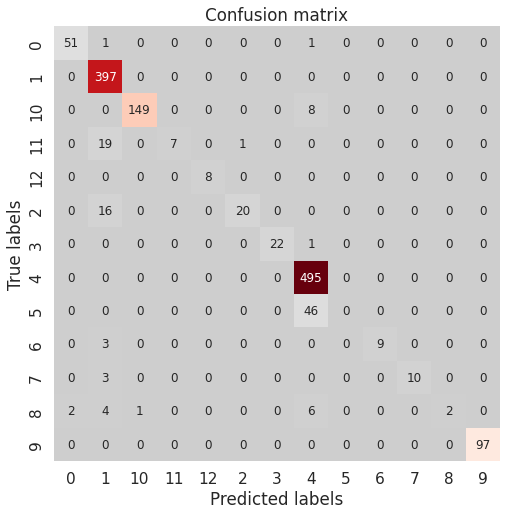

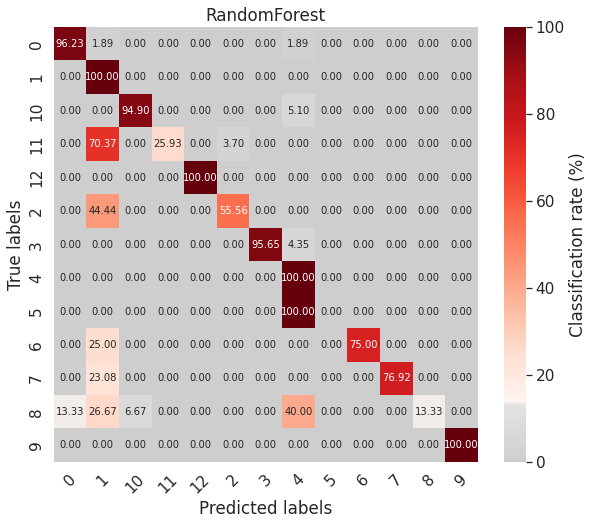

Accuracy: 0.9187817258883249: Misclassification: 0.08121827411167515
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        53
           1       0.90      1.00      0.95       397
          10       0.99      0.95      0.97       157
          11       1.00      0.26      0.41        27
          12       1.00      1.00      1.00         8
           2       0.95      0.56      0.70        36
           3       1.00      0.96      0.98        23
           4       0.89      1.00      0.94       495
           5       0.00      0.00      0.00        46
           6       1.00      0.75      0.86        12
           7       1.00      0.77      0.87        13
           8       1.00      0.13      0.24        15
           9       1.00      1.00      1.00        97

    accuracy                           0.92      1379
   macro avg       0.90      0.72      0.76      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Transforming to str index.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

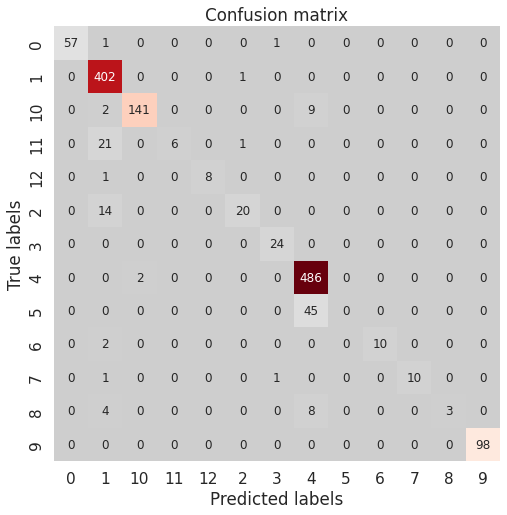

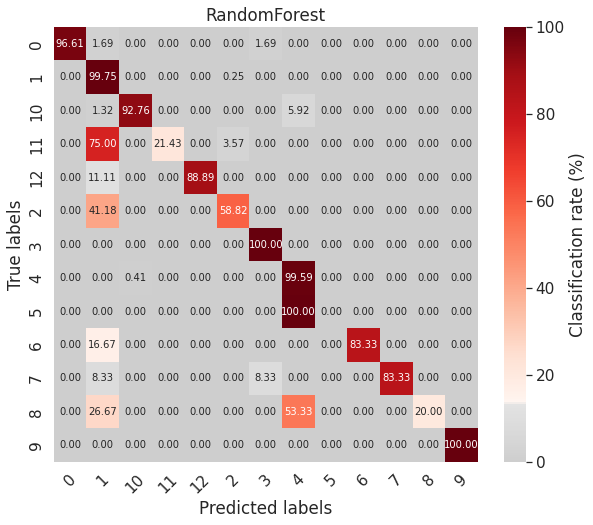

Accuracy: 0.9173313995649021: Misclassification: 0.08266860043509794
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        59
           1       0.90      1.00      0.94       403
          10       0.99      0.93      0.96       152
          11       1.00      0.21      0.35        28
          12       1.00      0.89      0.94         9
           2       0.91      0.59      0.71        34
           3       0.92      1.00      0.96        24
           4       0.89      1.00      0.94       488
           5       0.00      0.00      0.00        45
           6       1.00      0.83      0.91        12
           7       1.00      0.83      0.91        12
           8       1.00      0.20      0.33        15
           9       1.00      1.00      1.00        98

    accuracy                           0.92      1379
   macro avg       0.89      0.73      0.76      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Transforming to str index.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

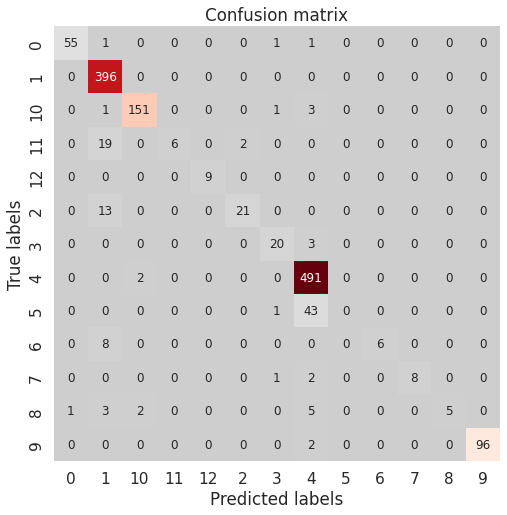

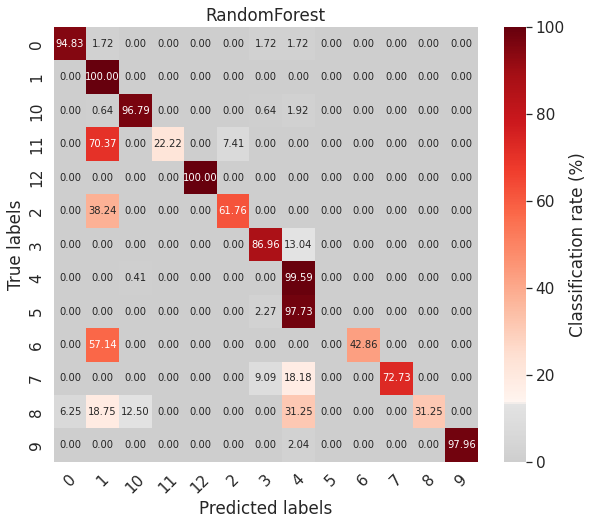

Accuracy: 0.9166062364031907: Misclassification: 0.08339376359680928
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        58
           1       0.90      1.00      0.95       396
          10       0.97      0.97      0.97       156
          11       1.00      0.22      0.36        27
          12       1.00      1.00      1.00         9
           2       0.91      0.62      0.74        34
           3       0.83      0.87      0.85        23
           4       0.89      1.00      0.94       493
           5       0.00      0.00      0.00        44
           6       1.00      0.43      0.60        14
           7       1.00      0.73      0.84        11
           8       1.00      0.31      0.48        16
           9       1.00      0.98      0.99        98

    accuracy                           0.92      1379
   macro avg       0.88      0.70      0.74      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Transforming to str index.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

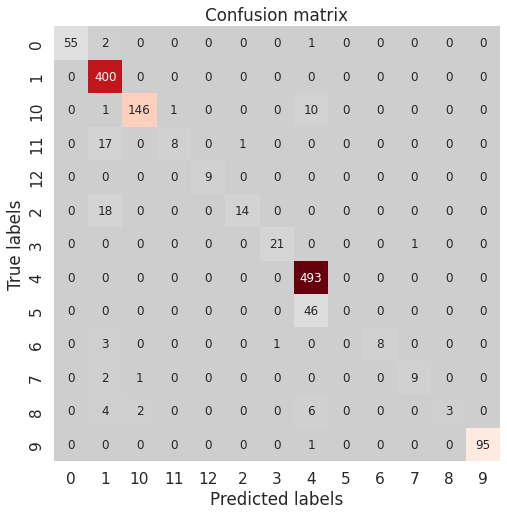

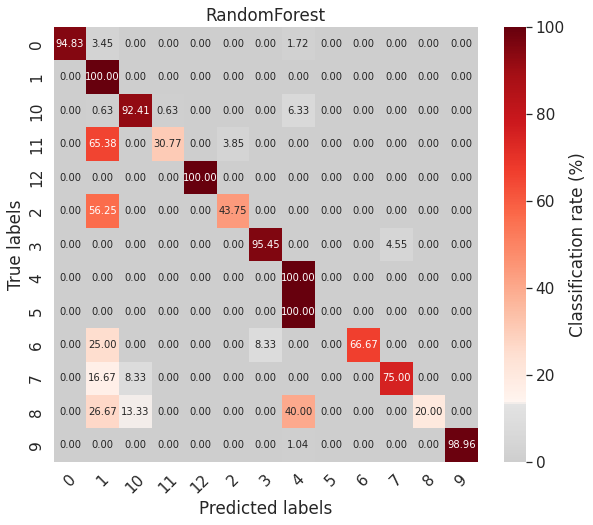

Accuracy: 0.9144307469180566: Misclassification: 0.08556925308194341
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        58
           1       0.89      1.00      0.94       400
          10       0.98      0.92      0.95       158
          11       0.89      0.31      0.46        26
          12       1.00      1.00      1.00         9
           2       0.93      0.44      0.60        32
           3       0.95      0.95      0.95        22
           4       0.89      1.00      0.94       493
           5       0.00      0.00      0.00        46
           6       1.00      0.67      0.80        12
           7       0.90      0.75      0.82        12
           8       1.00      0.20      0.33        15
           9       1.00      0.99      0.99        96

    accuracy                           0.91      1379
   macro avg       0.88      0.71      0.75      1379
weighted avg       0.89      0.91      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Transforming to str index.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

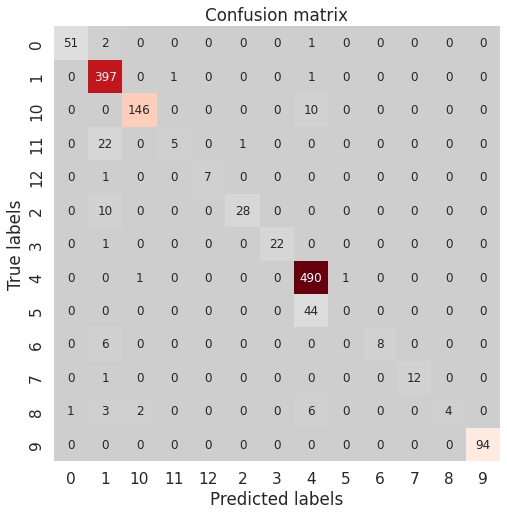

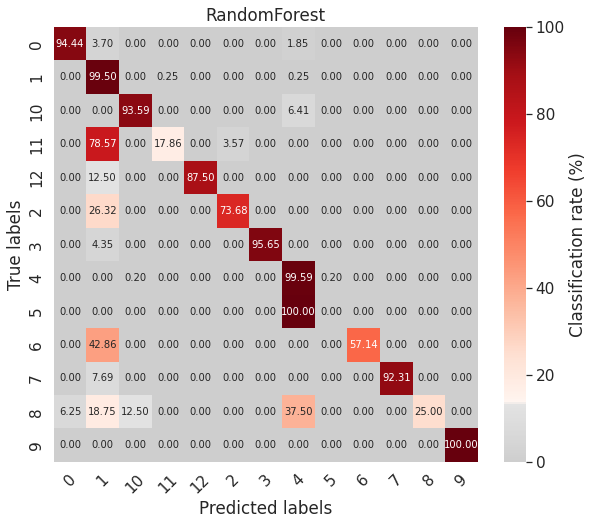

Accuracy: 0.9166062364031907: Misclassification: 0.08339376359680928
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        54
           1       0.90      0.99      0.94       399
          10       0.98      0.94      0.96       156
          11       0.83      0.18      0.29        28
          12       1.00      0.88      0.93         8
           2       0.97      0.74      0.84        38
           3       1.00      0.96      0.98        23
           4       0.89      1.00      0.94       492
           5       0.00      0.00      0.00        44
           6       1.00      0.57      0.73        14
           7       1.00      0.92      0.96        13
           8       1.00      0.25      0.40        16
           9       1.00      1.00      1.00        94

    accuracy                           0.92      1379
   macro avg       0.89      0.72      0.76      1379
weighted avg       0.89      0.92      0.89      1379

CPU times:

In [ ]:
%%time
for k in k_range:
    # The smashpy methods set global seeds that mess with sampling. These seeds are used 
    # to stop those methods from using the same global seed over and over.
    np.random.seed(possible_seeds[seed_index])
    seed_index += 1
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = SmashPyWrapper.prepareData(X, y, train_indices, val_indices, 'annotation')
    sm = smashpy.smashpy()
    clf = sm.ensemble_learning(train_X_y, group_by="annotation", classifier="RandomForest", balance=True, verbose=True)
    selectedGenes, selectedGenes_dict = sm.gini_importance(train_X_y, clf, group_by="annotation", verbose=True, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = train_X_y.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_rf_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'smash_rf_markers_k_{}.npy'.format(k), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_rf_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    plot_umap_embedding(X, y, encoder, 'Smash Random Forest Marker Visualization', path = viz_save_path + 'smash_rf_markers_k_{}.png'.format(k), markers = smash_markers, close_fig = True)

 * Initialising ...
Running with (Weighted) Random Forest


Transforming to str index.


<Figure size 432x288 with 0 Axes>

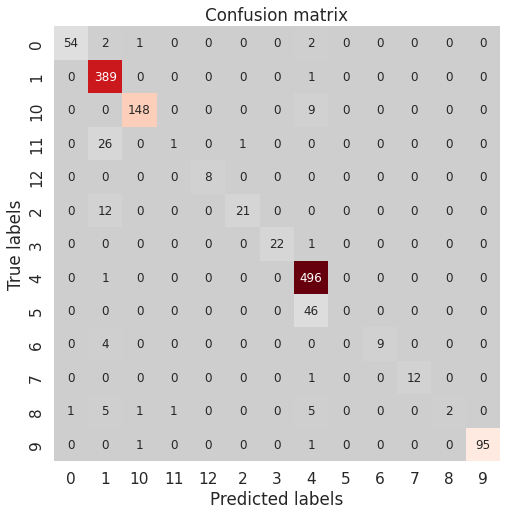

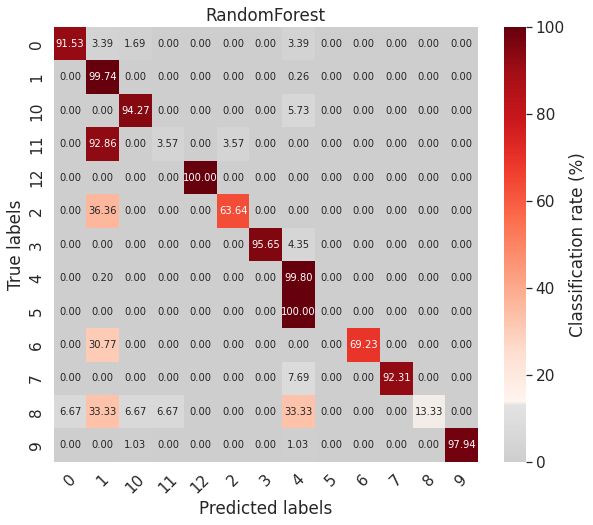

Accuracy: 0.911530094271211: Misclassification: 0.08846990572878899
              precision    recall  f1-score   support

           0       0.98      0.92      0.95        59
           1       0.89      1.00      0.94       390
          10       0.98      0.94      0.96       157
          11       0.50      0.04      0.07        28
          12       1.00      1.00      1.00         8
           2       0.95      0.64      0.76        33
           3       1.00      0.96      0.98        23
           4       0.88      1.00      0.94       497
           5       0.00      0.00      0.00        46
           6       1.00      0.69      0.82        13
           7       1.00      0.92      0.96        13
           8       1.00      0.13      0.24        15
           9       1.00      0.98      0.99        97

    accuracy                           0.91      1379
   macro avg       0.86      0.71      0.74      1379
weighted avg       0.88      0.91      0.88      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Transforming to str index.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

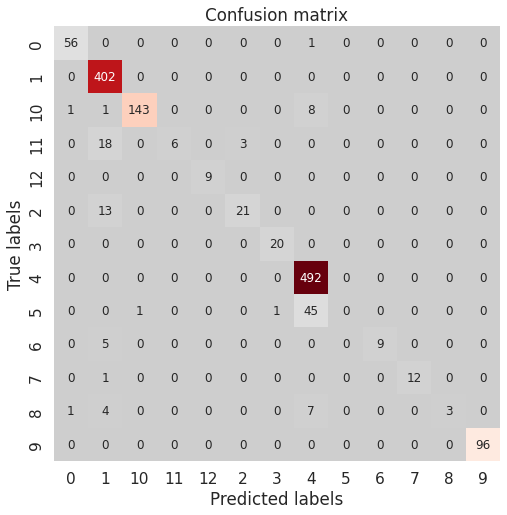

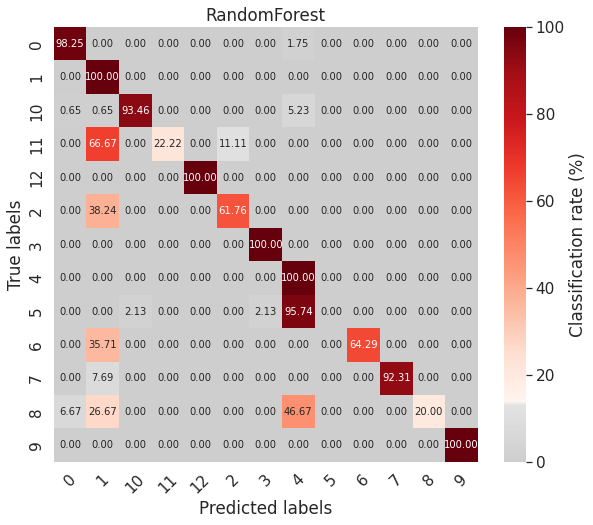

Accuracy: 0.9202320522117476: Misclassification: 0.07976794778825236
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        57
           1       0.91      1.00      0.95       402
          10       0.99      0.93      0.96       153
          11       1.00      0.22      0.36        27
          12       1.00      1.00      1.00         9
           2       0.88      0.62      0.72        34
           3       0.95      1.00      0.98        20
           4       0.89      1.00      0.94       492
           5       0.00      0.00      0.00        47
           6       1.00      0.64      0.78        14
           7       1.00      0.92      0.96        13
           8       1.00      0.20      0.33        15
           9       1.00      1.00      1.00        96

    accuracy                           0.92      1379
   macro avg       0.89      0.73      0.77      1379
weighted avg       0.89      0.92      0.90      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Transforming to str index.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

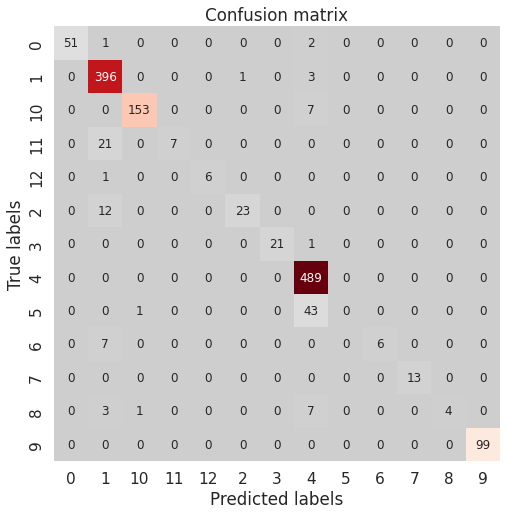

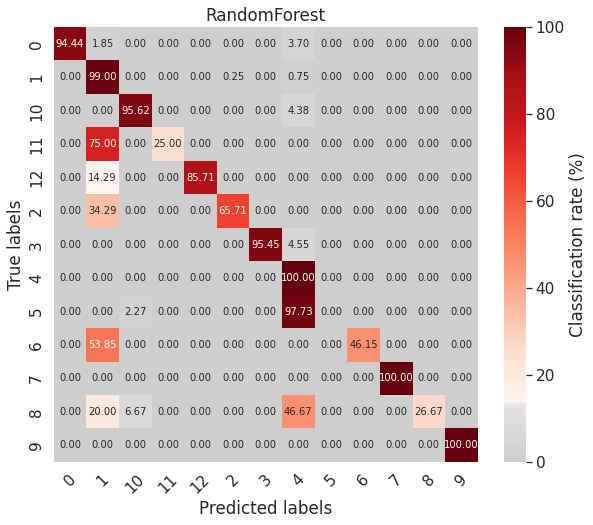

Accuracy: 0.9195068890500363: Misclassification: 0.0804931109499637
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        54
           1       0.90      0.99      0.94       400
          10       0.99      0.96      0.97       160
          11       1.00      0.25      0.40        28
          12       1.00      0.86      0.92         7
           2       0.96      0.66      0.78        35
           3       1.00      0.95      0.98        22
           4       0.89      1.00      0.94       489
           5       0.00      0.00      0.00        44
           6       1.00      0.46      0.63        13
           7       1.00      1.00      1.00        13
           8       1.00      0.27      0.42        15
           9       1.00      1.00      1.00        99

    accuracy                           0.92      1379
   macro avg       0.90      0.72      0.77      1379
weighted avg       0.90      0.92      0.90      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Transforming to str index.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

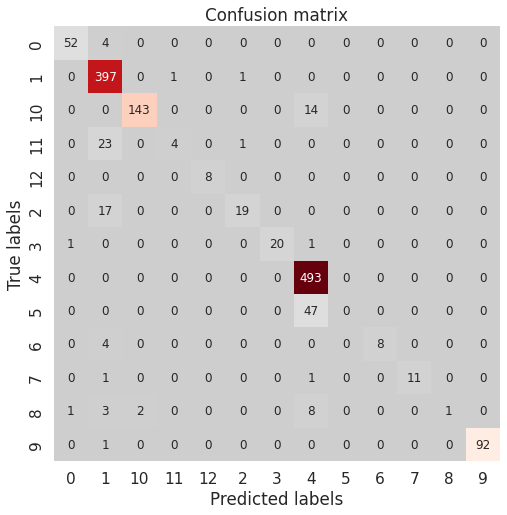

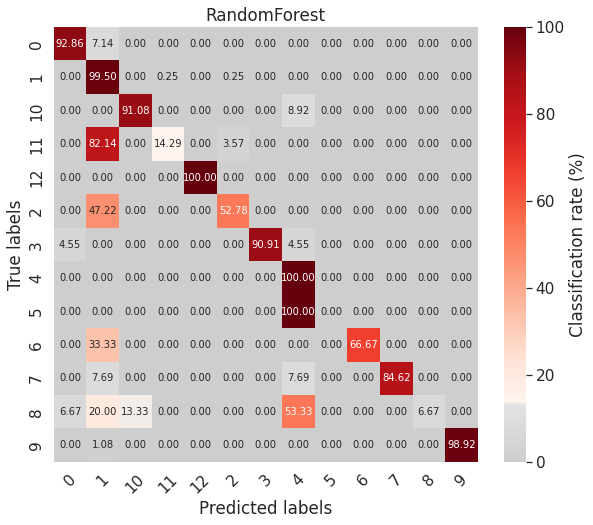

Accuracy: 0.9050036258158085: Misclassification: 0.09499637418419149
              precision    recall  f1-score   support

           0       0.96      0.93      0.95        56
           1       0.88      0.99      0.94       399
          10       0.99      0.91      0.95       157
          11       0.80      0.14      0.24        28
          12       1.00      1.00      1.00         8
           2       0.90      0.53      0.67        36
           3       1.00      0.91      0.95        22
           4       0.87      1.00      0.93       493
           5       0.00      0.00      0.00        47
           6       1.00      0.67      0.80        12
           7       1.00      0.85      0.92        13
           8       1.00      0.07      0.12        15
           9       1.00      0.99      0.99        93

    accuracy                           0.91      1379
   macro avg       0.88      0.69      0.73      1379
weighted avg       0.88      0.91      0.88      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Transforming to str index.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

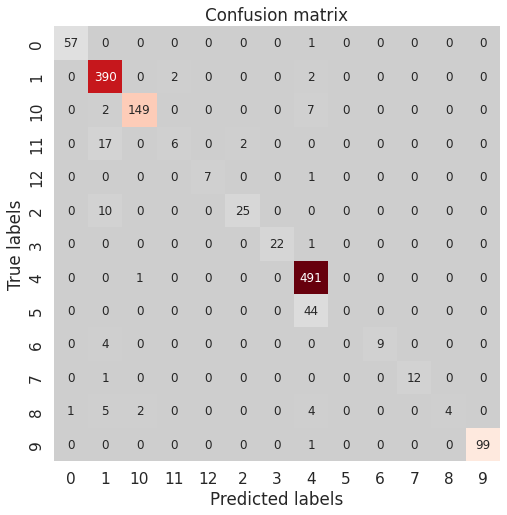

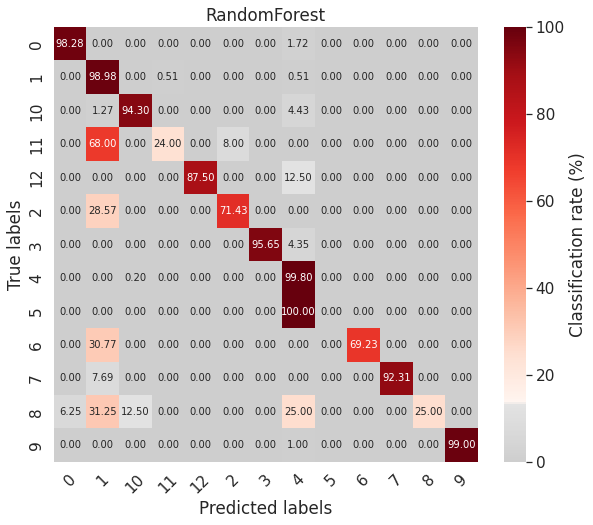

Accuracy: 0.9216823785351704: Misclassification: 0.07831762146482957
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        58
           1       0.91      0.99      0.95       394
          10       0.98      0.94      0.96       158
          11       0.75      0.24      0.36        25
          12       1.00      0.88      0.93         8
           2       0.93      0.71      0.81        35
           3       1.00      0.96      0.98        23
           4       0.89      1.00      0.94       492
           5       0.00      0.00      0.00        44
           6       1.00      0.69      0.82        13
           7       1.00      0.92      0.96        13
           8       1.00      0.25      0.40        16
           9       1.00      0.99      0.99       100

    accuracy                           0.92      1379
   macro avg       0.88      0.73      0.78      1379
weighted avg       0.89      0.92      0.90      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Transforming to str index.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

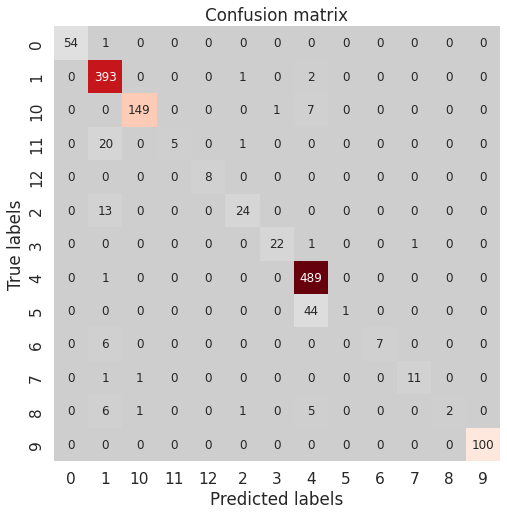

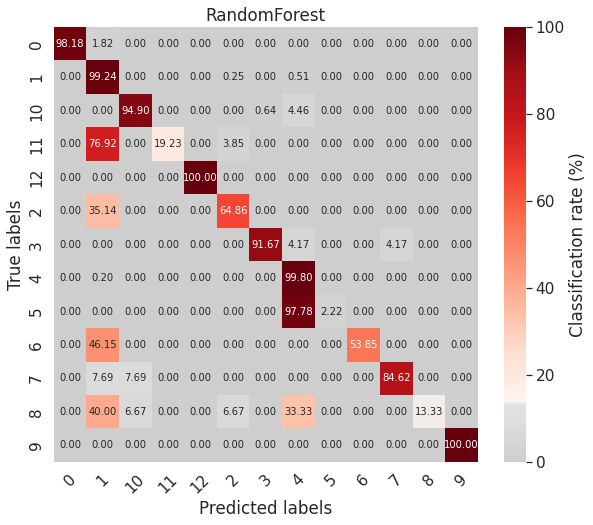

Accuracy: 0.9173313995649021: Misclassification: 0.08266860043509794
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        55
           1       0.89      0.99      0.94       396
          10       0.99      0.95      0.97       157
          11       1.00      0.19      0.32        26
          12       1.00      1.00      1.00         8
           2       0.89      0.65      0.75        37
           3       0.96      0.92      0.94        24
           4       0.89      1.00      0.94       490
           5       1.00      0.02      0.04        45
           6       1.00      0.54      0.70        13
           7       0.92      0.85      0.88        13
           8       1.00      0.13      0.24        15
           9       1.00      1.00      1.00       100

    accuracy                           0.92      1379
   macro avg       0.96      0.71      0.75      1379
weighted avg       0.92      0.92      0.89      1379



Transforming to str index.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

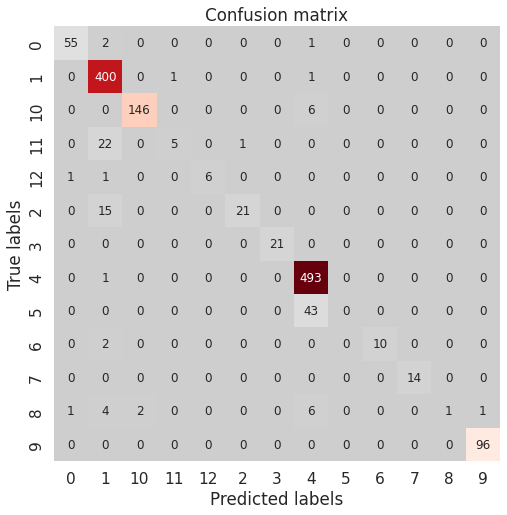

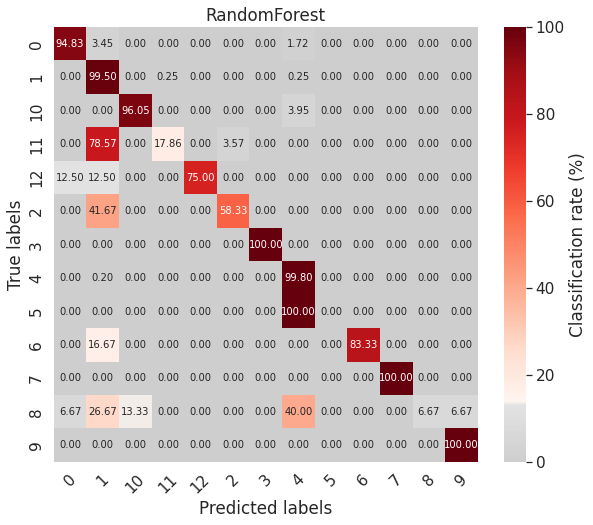

Accuracy: 0.9195068890500363: Misclassification: 0.0804931109499637
              precision    recall  f1-score   support

           0       0.96      0.95      0.96        58
           1       0.89      1.00      0.94       402
          10       0.99      0.96      0.97       152
          11       0.83      0.18      0.29        28
          12       1.00      0.75      0.86         8
           2       0.95      0.58      0.72        36
           3       1.00      1.00      1.00        21
           4       0.90      1.00      0.94       494
           5       0.00      0.00      0.00        43
           6       1.00      0.83      0.91        12
           7       1.00      1.00      1.00        14
           8       1.00      0.07      0.12        15
           9       0.99      1.00      0.99        96

    accuracy                           0.92      1379
   macro avg       0.89      0.72      0.75      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Transforming to str index.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

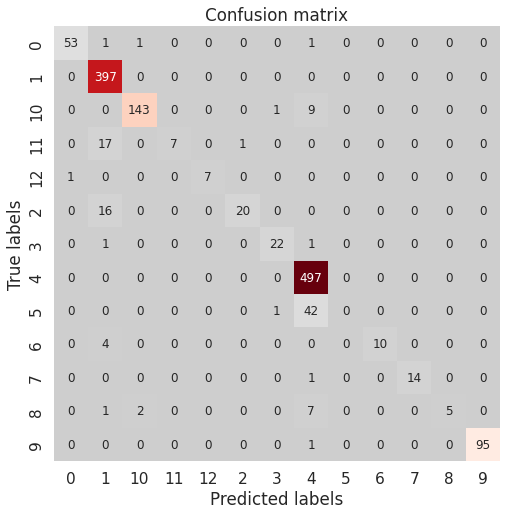

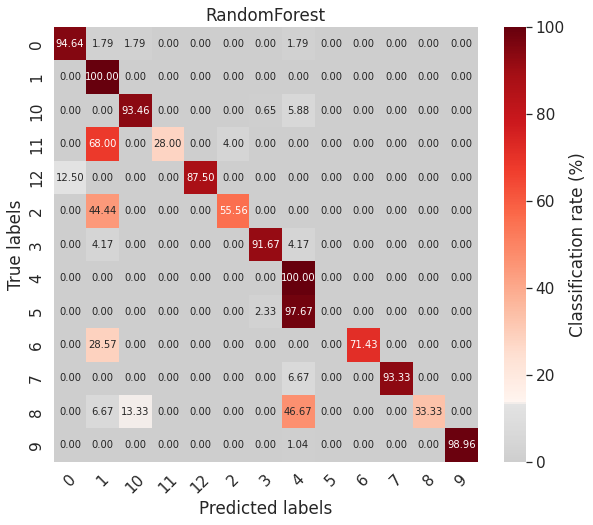

Accuracy: 0.920957215373459: Misclassification: 0.07904278462654102
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        56
           1       0.91      1.00      0.95       397
          10       0.98      0.93      0.96       153
          11       1.00      0.28      0.44        25
          12       1.00      0.88      0.93         8
           2       0.95      0.56      0.70        36
           3       0.92      0.92      0.92        24
           4       0.89      1.00      0.94       497
           5       0.00      0.00      0.00        43
           6       1.00      0.71      0.83        14
           7       1.00      0.93      0.97        15
           8       1.00      0.33      0.50        15
           9       1.00      0.99      0.99        96

    accuracy                           0.92      1379
   macro avg       0.89      0.73      0.78      1379
weighted avg       0.90      0.92      0.90      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Transforming to str index.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

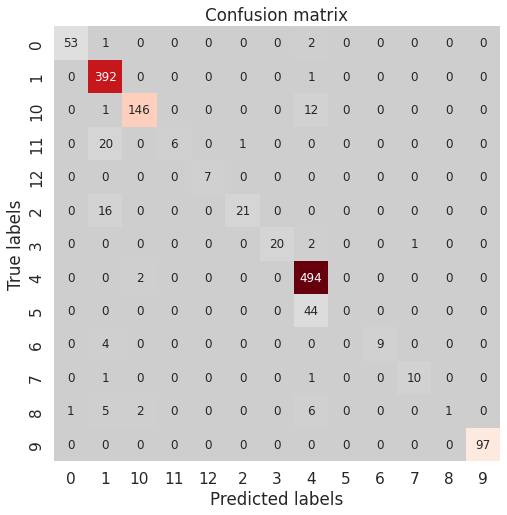

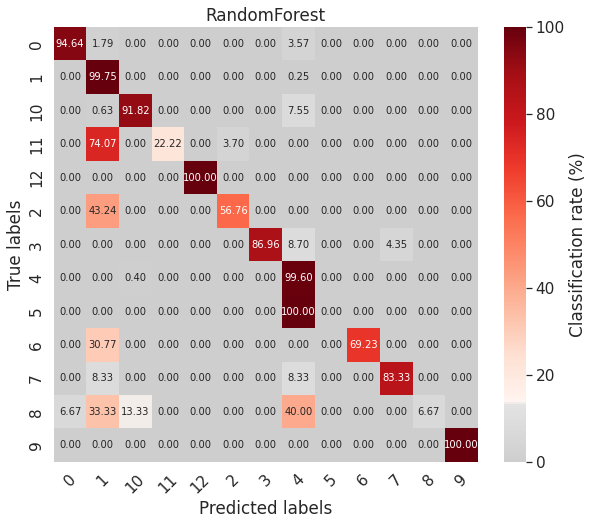

Accuracy: 0.9108049311094997: Misclassification: 0.08919506889050033
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        56
           1       0.89      1.00      0.94       393
          10       0.97      0.92      0.94       159
          11       1.00      0.22      0.36        27
          12       1.00      1.00      1.00         7
           2       0.95      0.57      0.71        37
           3       1.00      0.87      0.93        23
           4       0.88      1.00      0.93       496
           5       0.00      0.00      0.00        44
           6       1.00      0.69      0.82        13
           7       0.91      0.83      0.87        12
           8       1.00      0.07      0.12        15
           9       1.00      1.00      1.00        97

    accuracy                           0.91      1379
   macro avg       0.89      0.70      0.74      1379
weighted avg       0.89      0.91      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Transforming to str index.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

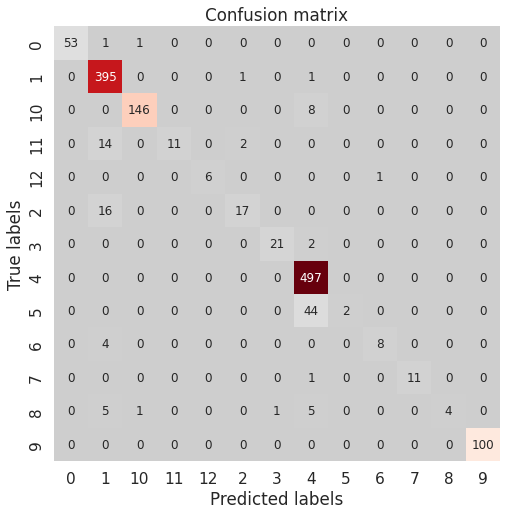

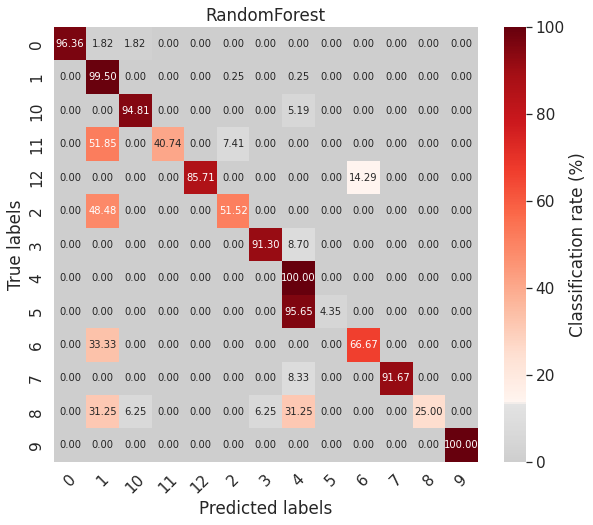

Accuracy: 0.9216823785351704: Misclassification: 0.07831762146482957
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        55
           1       0.91      0.99      0.95       397
          10       0.99      0.95      0.97       154
          11       1.00      0.41      0.58        27
          12       1.00      0.86      0.92         7
           2       0.85      0.52      0.64        33
           3       0.95      0.91      0.93        23
           4       0.89      1.00      0.94       497
           5       1.00      0.04      0.08        46
           6       0.89      0.67      0.76        12
           7       1.00      0.92      0.96        12
           8       1.00      0.25      0.40        16
           9       1.00      1.00      1.00       100

    accuracy                           0.92      1379
   macro avg       0.96      0.73      0.78      1379
weighted avg       0.93      0.92      0.90      1379

CPU times:

In [ ]:
%%time
k = 50
for tryy in range(1,num_times+1):
    # The smashpy methods set global seeds that mess with sampling. These seeds are used 
    # to stop those methods from using the same global seed over and over.
    np.random.seed(possible_seeds[seed_index])
    seed_index += 1
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = SmashPyWrapper.prepareData(X, y, train_indices, val_indices, 'annotation')
    sm = smashpy.smashpy()
    clf = sm.ensemble_learning(train_X_y, group_by="annotation", classifier="RandomForest", balance=True, verbose=True)
    selectedGenes, selectedGenes_dict = sm.gini_importance(train_X_y, clf, group_by="annotation", verbose=True, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = train_X_y.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_rf_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_rf_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_rf_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    plot_umap_embedding(X, y, encoder, 'Smash Random Forest Marker Visualization', path = viz_save_path + 'smash_rf_markers_{}.png'.format(tryy), markers = smash_markers, close_fig = True)

## Train Smash DNN

the data is treated a bit differently than our other models

 * Initialising ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                16032     
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
activation_1 (Activation)    (None, 

Transforming to str index.
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Epoch 1/100
56/56 [==============================] - 3s 19ms/step - loss: 2.4225 - accuracy: 0.1473 - auc: 0.7051 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3411 - val_accuracy: 0.2255 - val_auc: 0.7634 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00001: val_loss improved from inf to 2.34115, saving model to weights/best_model_annotation.h5
Epoch 2/100
56/56 [==============================] - 0s 8ms/step - loss: 2.1953 - accuracy: 0.3016 - auc: 0.7979 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2562 - val_accuracy: 0.4293 - val_auc: 0.8852 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00002: val_loss improved from 2.34115 to 2.25616, saving model to weights/best_model_annotation.h5
Epoch 3/100
56/56 [==============================] - 0s 8ms/step - loss: 2.0562 - accuracy: 0.4207 - auc: 0.8448 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.1592 - val_accuracy: 0.5221 - val_auc: 0.9367 - val_precision: 0.0000e+00 - v

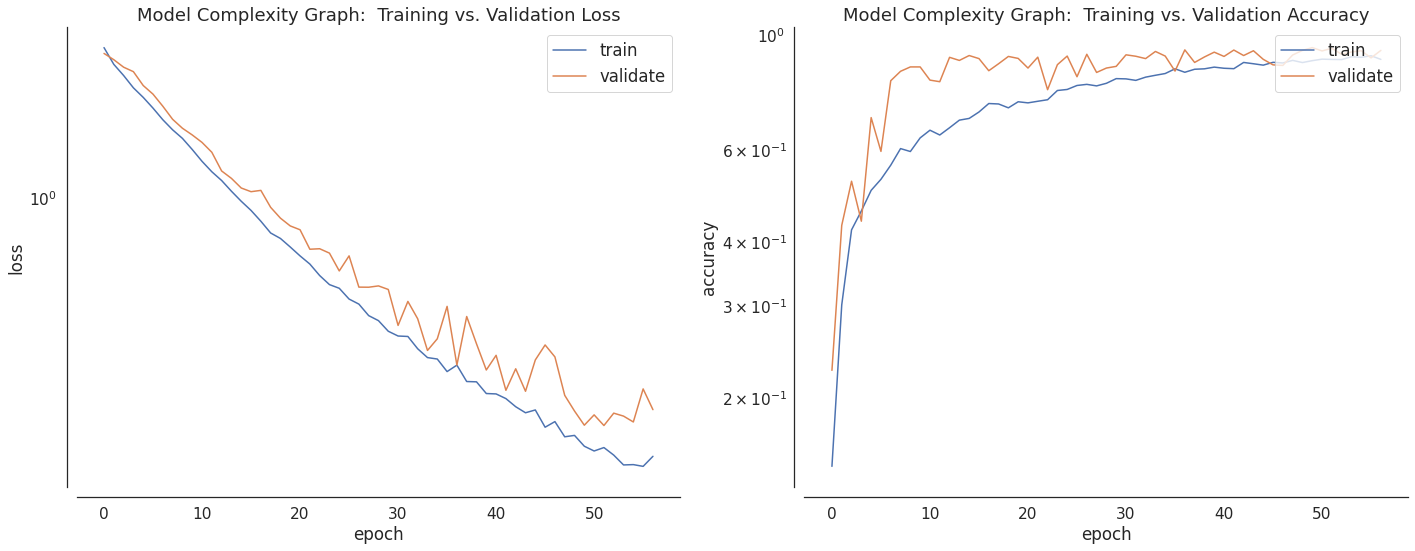

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

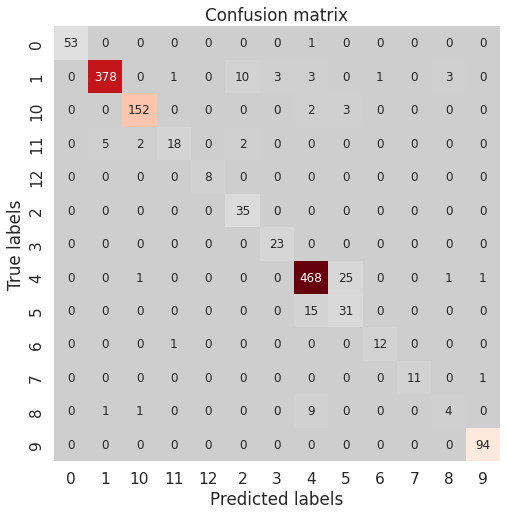

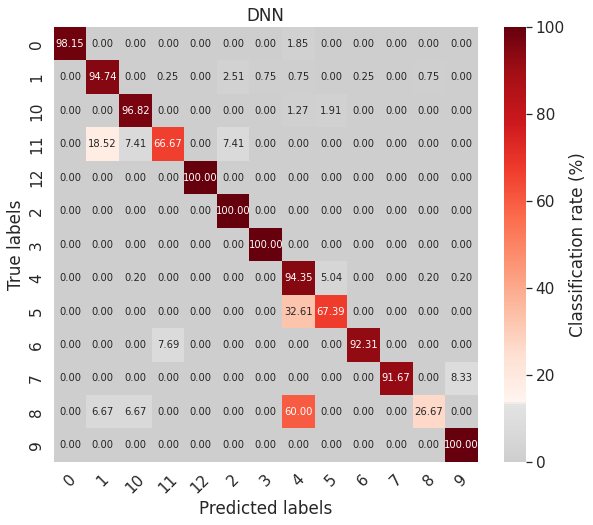

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        54
           1       0.98      0.95      0.97       399
          10       0.97      0.97      0.97       157
          11       0.90      0.67      0.77        27
          12       1.00      1.00      1.00         8
           2       0.74      1.00      0.85        35
           3       0.88      1.00      0.94        23
           4       0.94      0.94      0.94       496
           5       0.53      0.67      0.59        46
           6       0.92      0.92      0.92        13
           7       1.00      0.92      0.96        12
           8       0.50      0.27      0.35        15
           9       0.98      1.00      0.99        94

    accuracy                           0.93      1379
   macro avg       0.87      0.87      0.86      1379
weighted avg       0.94      0.93      0.93      1379

44/44 [==============================] - 0s 3ms/step - loss: 0.2624 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


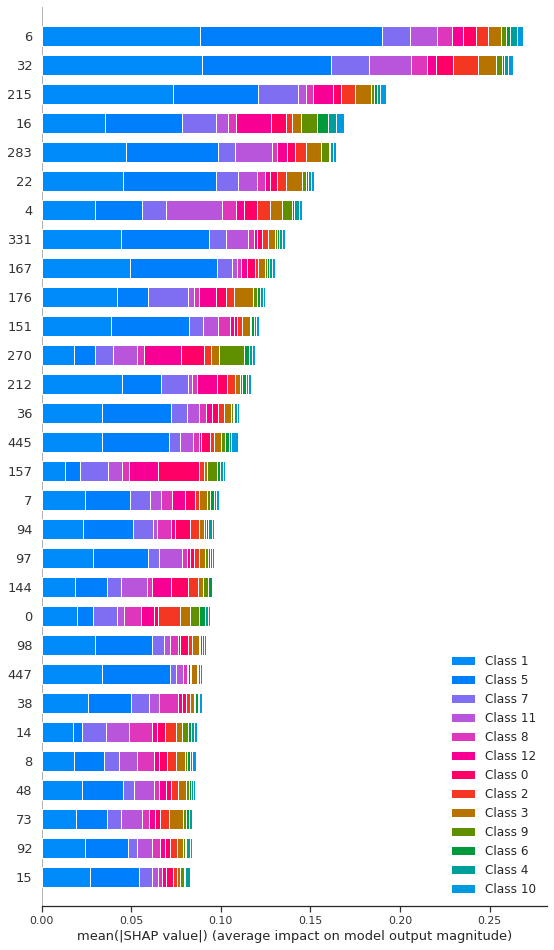

Transforming to str index.


 * Initialising ...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                16032     
_________________________________________________________________
batch_normalization_4 (Batch (None, 32)                128       
_________________________________________________________________
activation_4 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_5 (Batch (None, 16)                64        
_________________________________________________________________
activation_5 (Activation)    (None

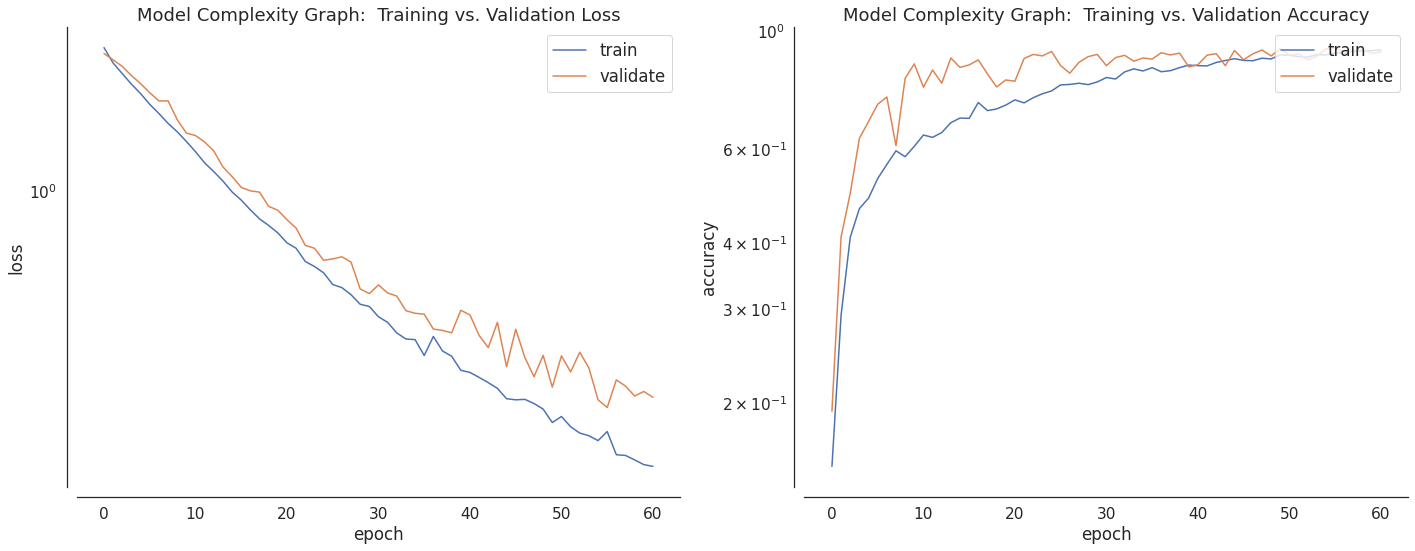

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

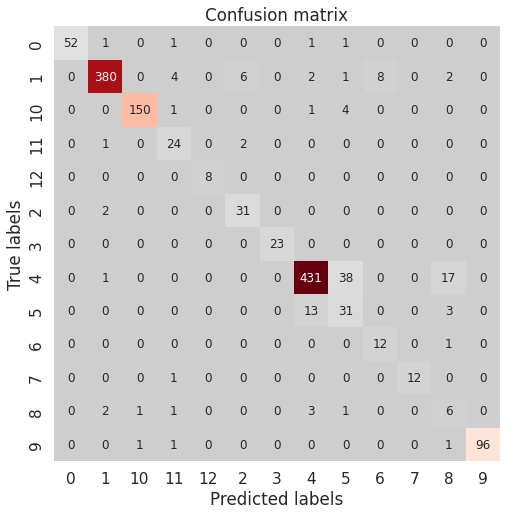

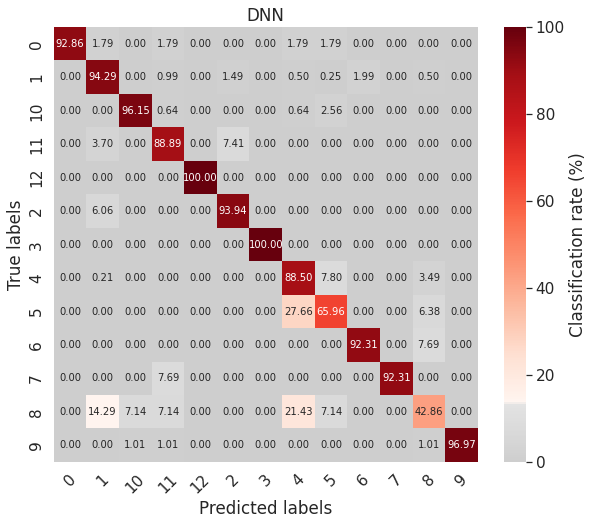

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        56
           1       0.98      0.94      0.96       403
          10       0.99      0.96      0.97       156
          11       0.73      0.89      0.80        27
          12       1.00      1.00      1.00         8
           2       0.79      0.94      0.86        33
           3       1.00      1.00      1.00        23
           4       0.96      0.89      0.92       487
           5       0.41      0.66      0.50        47
           6       0.60      0.92      0.73        13
           7       1.00      0.92      0.96        13
           8       0.20      0.43      0.27        14
           9       1.00      0.97      0.98        99

    accuracy                           0.91      1379
   macro avg       0.82      0.88      0.84      1379
weighted avg       0.94      0.91      0.92      1379

44/44 [==============================] - 0s 3ms/step - loss: 0.2601 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


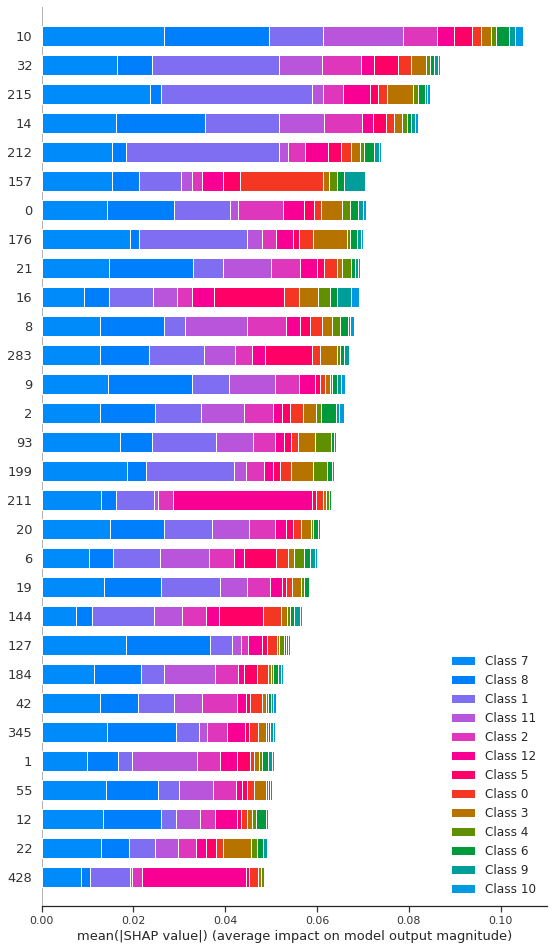

Transforming to str index.


 * Initialising ...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________________________________________________________________
activation_8 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_9 (Batch (None, 16)                64        
_________________________________________________________________
activation_9 (Activation)    (None

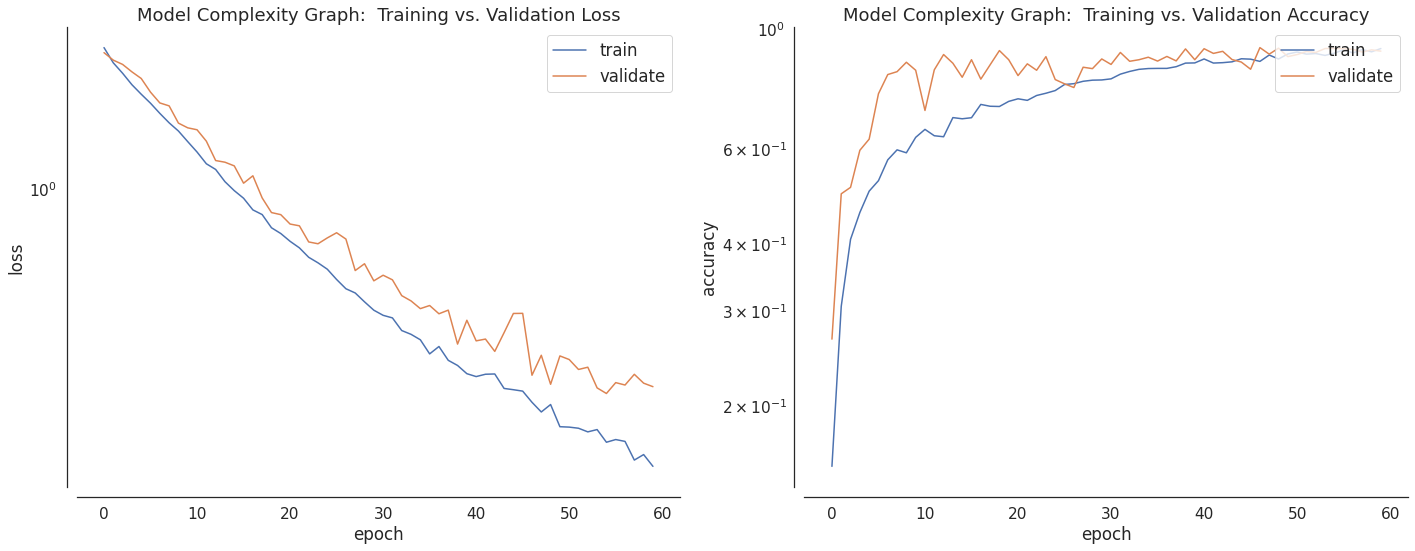

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

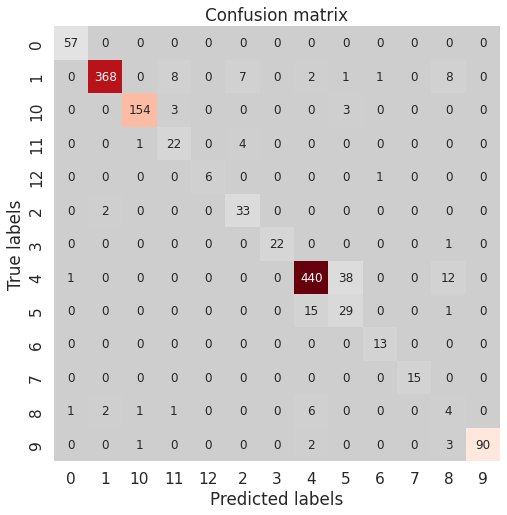

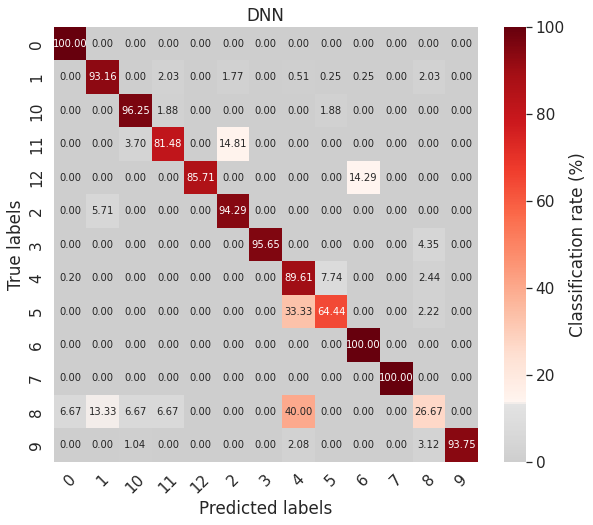

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        57
           1       0.99      0.93      0.96       395
          10       0.98      0.96      0.97       160
          11       0.65      0.81      0.72        27
          12       1.00      0.86      0.92         7
           2       0.75      0.94      0.84        35
           3       1.00      0.96      0.98        23
           4       0.95      0.90      0.92       491
           5       0.41      0.64      0.50        45
           6       0.87      1.00      0.93        13
           7       1.00      1.00      1.00        15
           8       0.14      0.27      0.18        15
           9       1.00      0.94      0.97        96

    accuracy                           0.91      1379
   macro avg       0.82      0.86      0.84      1379
weighted avg       0.93      0.91      0.92      1379

44/44 [==============================] - 0s 3ms/step - loss: 0.2793 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


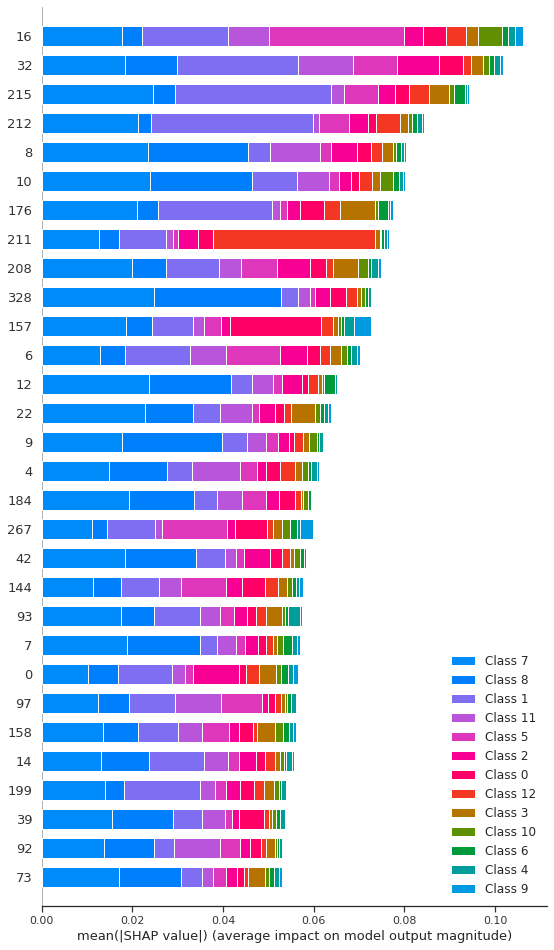

Transforming to str index.


 * Initialising ...
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_12 (Batc (None, 32)                128       
_________________________________________________________________
activation_12 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_13 (Batc (None, 16)                64        
_________________________________________________________________
activation_13 (Activation)   (None

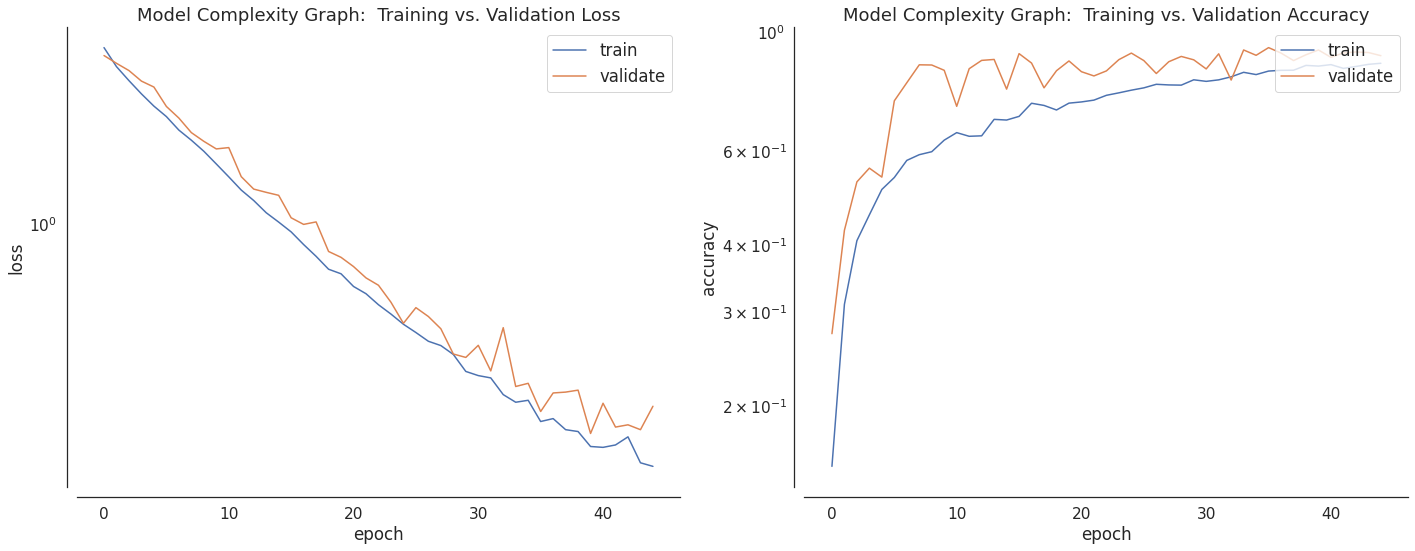

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

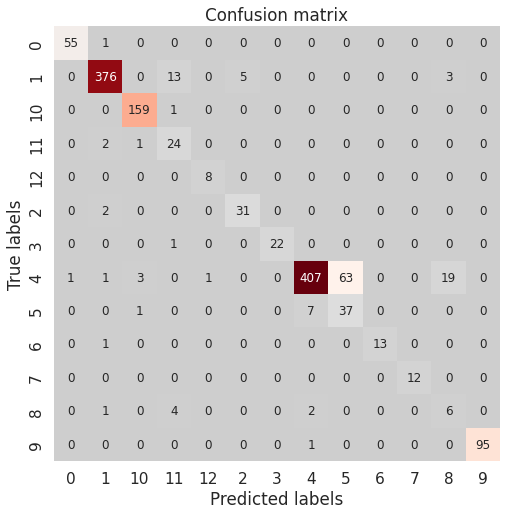

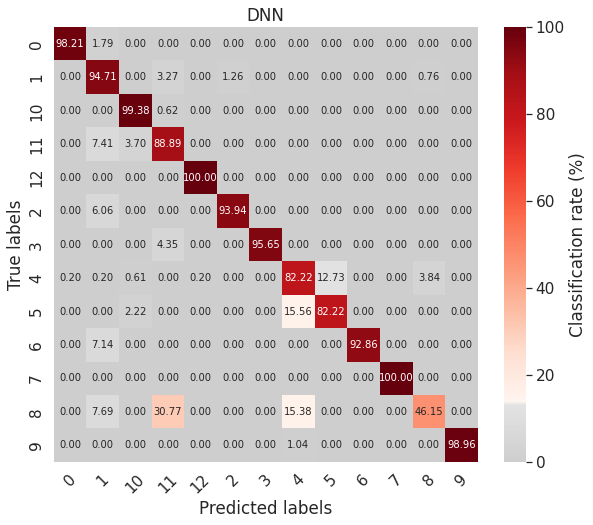

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        56
           1       0.98      0.95      0.96       397
          10       0.97      0.99      0.98       160
          11       0.56      0.89      0.69        27
          12       0.89      1.00      0.94         8
           2       0.86      0.94      0.90        33
           3       1.00      0.96      0.98        23
           4       0.98      0.82      0.89       495
           5       0.37      0.82      0.51        45
           6       1.00      0.93      0.96        14
           7       1.00      1.00      1.00        12
           8       0.21      0.46      0.29        13
           9       1.00      0.99      0.99        96

    accuracy                           0.90      1379
   macro avg       0.83      0.90      0.85      1379
weighted avg       0.94      0.90      0.92      1379

44/44 [==============================] - 0s 3ms/step - loss: 0.3471 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


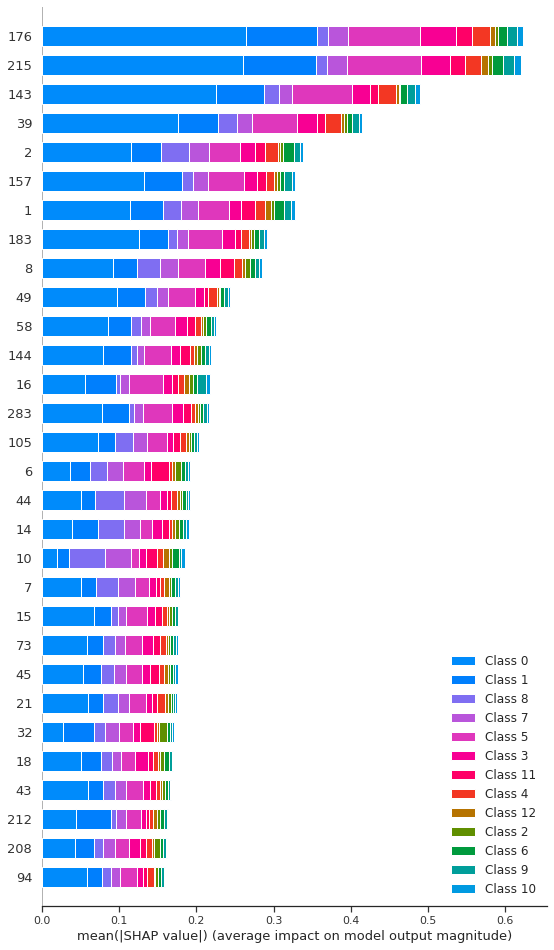

Transforming to str index.


 * Initialising ...
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_16 (Batc (None, 32)                128       
_________________________________________________________________
activation_16 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_17 (Batc (None, 16)                64        
_________________________________________________________________
activation_17 (Activation)   (None

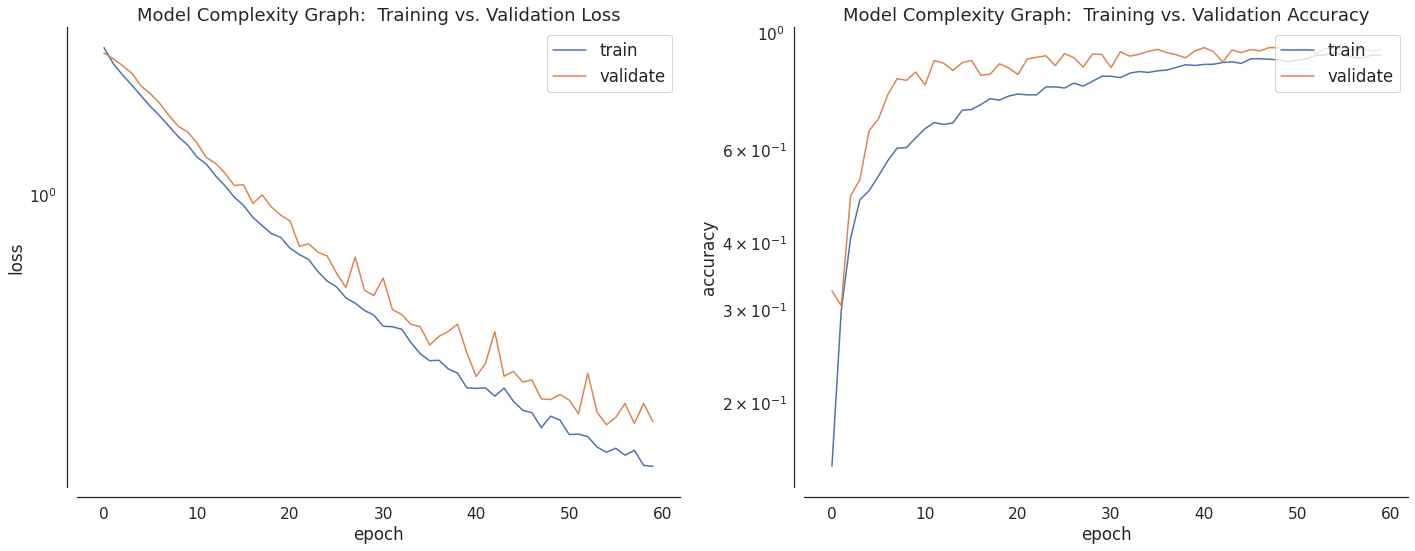

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

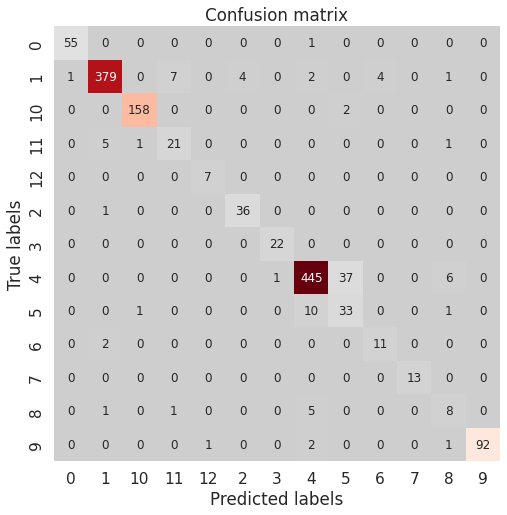

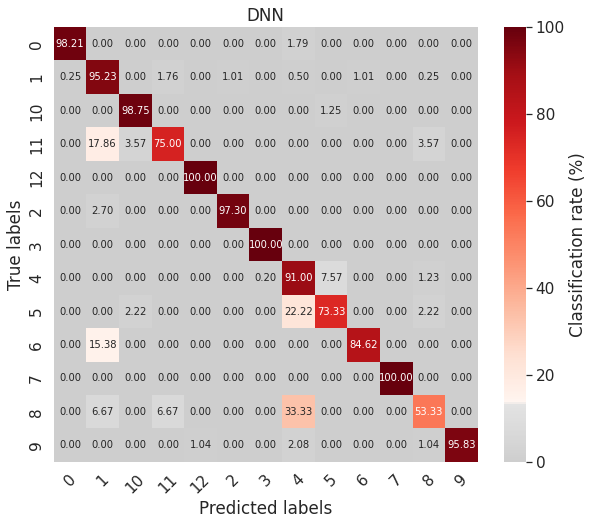

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        56
           1       0.98      0.95      0.96       398
          10       0.99      0.99      0.99       160
          11       0.72      0.75      0.74        28
          12       0.88      1.00      0.93         7
           2       0.90      0.97      0.94        37
           3       0.96      1.00      0.98        22
           4       0.96      0.91      0.93       489
           5       0.46      0.73      0.56        45
           6       0.73      0.85      0.79        13
           7       1.00      1.00      1.00        13
           8       0.44      0.53      0.48        15
           9       1.00      0.96      0.98        96

    accuracy                           0.93      1379
   macro avg       0.85      0.89      0.87      1379
weighted avg       0.94      0.93      0.93      1379

44/44 [==============================] - 0s 3ms/step - loss: 0.2510 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


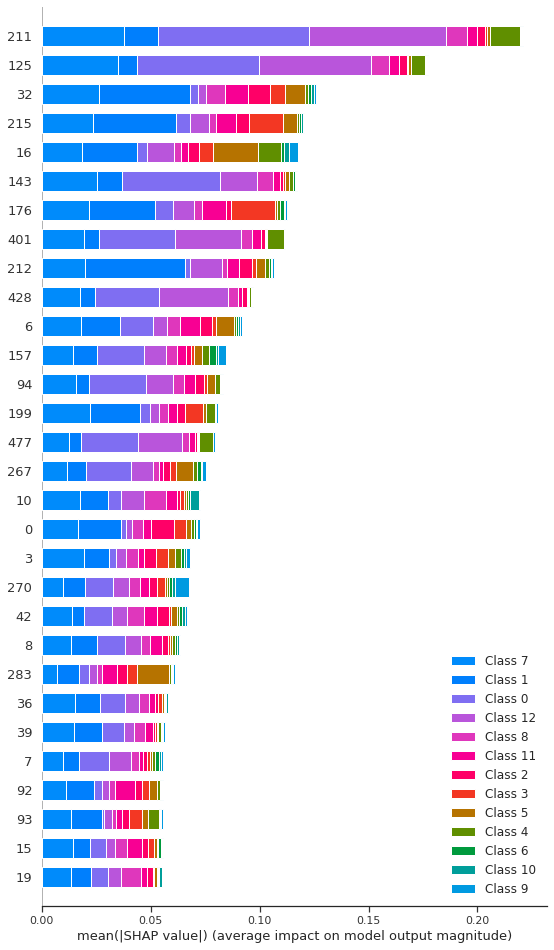

CPU times: user 8min, sys: 18.1 s, total: 8min 18s
Wall time: 6min 47s


In [ ]:
%%time
for k in k_range:
    # The smashpy methods set global seeds that mess with sampling. These seeds are used 
    # to stop those methods from using the same global seed over and over.
    np.random.seed(possible_seeds[seed_index])
    seed_index += 1
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = SmashPyWrapper.prepareData(X, y, train_indices, val_indices, 'annotation')
    sm = smashpy.smashpy()
    sm.DNN(train_X_y, group_by="annotation", model=None, balance=True, verbose=True, save=False)
    selectedGenes, selectedGenes_dict = sm.run_shap(train_X_y, group_by="annotation", model=None, verbose=True, pct=0.1, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = train_X_y.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'smash_markers_k_{}.npy'.format(k), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    plot_umap_embedding(X, y, encoder, 'Smash Marker Visualization', path = viz_save_path + 'smash_markers_k_{}.png'.format(k), markers = smash_markers, close_fig = True)

 * Initialising ...
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_20 (Batc (None, 32)                128       
_________________________________________________________________
activation_20 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_21 (Batc (None, 16)                64        
_________________________________________________________________
activation_21 (Activation)   (Non

Transforming to str index.


Epoch 1/100
56/56 [==============================] - 3s 18ms/step - loss: 2.4203 - accuracy: 0.1422 - auc: 0.6940 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3419 - val_accuracy: 0.2342 - val_auc: 0.7638 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00001: val_loss improved from inf to 2.34191, saving model to weights/best_model_annotation.h5
Epoch 2/100
56/56 [==============================] - 0s 8ms/step - loss: 2.2073 - accuracy: 0.3049 - auc: 0.7951 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2575 - val_accuracy: 0.4249 - val_auc: 0.8844 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00002: val_loss improved from 2.34191 to 2.25755, saving model to weights/best_model_annotation.h5
Epoch 3/100
56/56 [==============================] - 0s 7ms/step - loss: 2.0571 - accuracy: 0.4151 - auc: 0.8404 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.1802 - val_accuracy: 0.4532 - val_auc: 0.9335 - val_precision: 0.0000e+00 - v

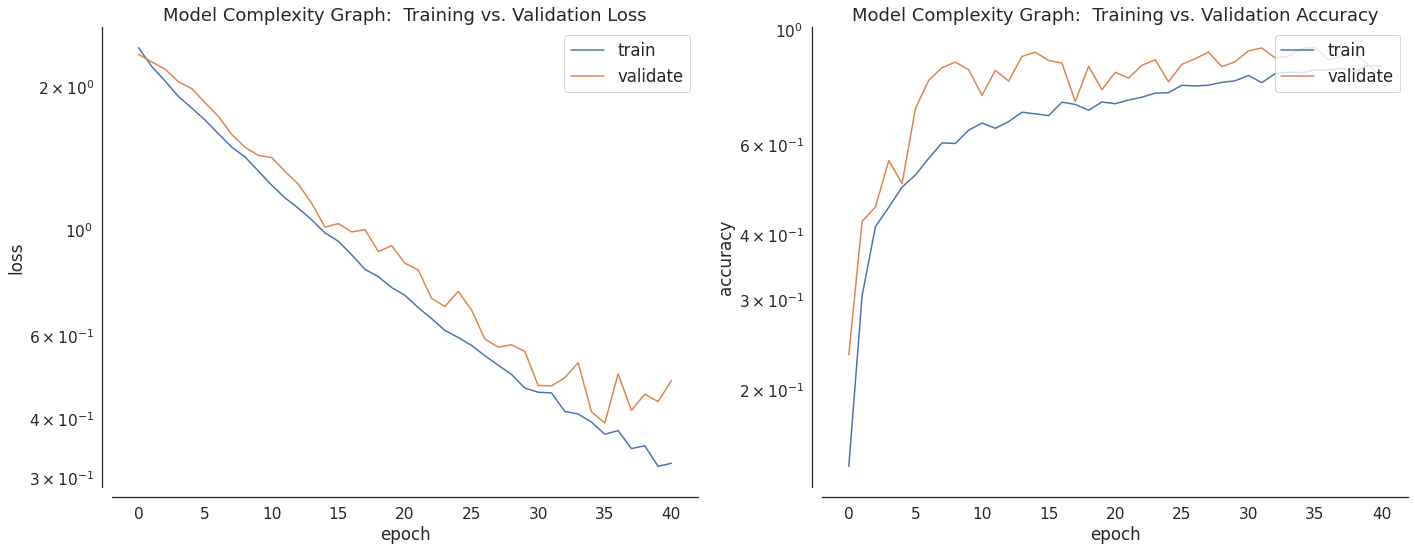

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

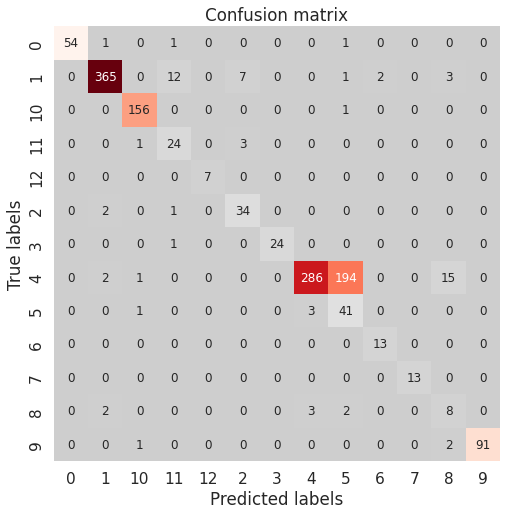

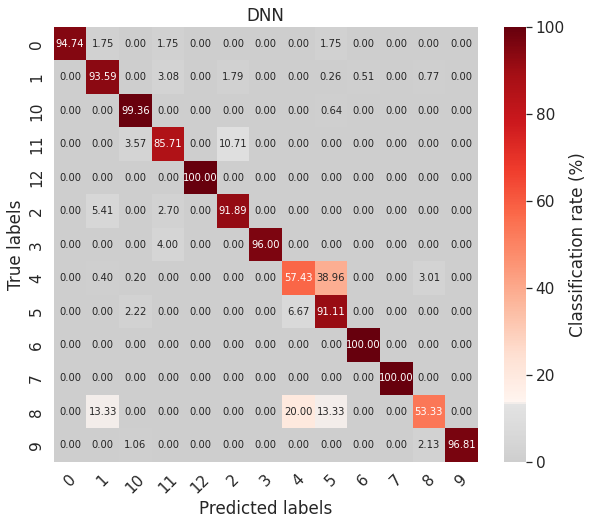

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        57
           1       0.98      0.94      0.96       390
          10       0.97      0.99      0.98       157
          11       0.62      0.86      0.72        28
          12       1.00      1.00      1.00         7
           2       0.77      0.92      0.84        37
           3       1.00      0.96      0.98        25
           4       0.98      0.57      0.72       498
           5       0.17      0.91      0.29        45
           6       0.87      1.00      0.93        13
           7       1.00      1.00      1.00        13
           8       0.29      0.53      0.37        15
           9       1.00      0.97      0.98        94

    accuracy                           0.81      1379
   macro avg       0.82      0.89      0.83      1379
weighted avg       0.93      0.81      0.84      1379

44/44 [==============================] - 0s 3ms/step - loss: 0.3916 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


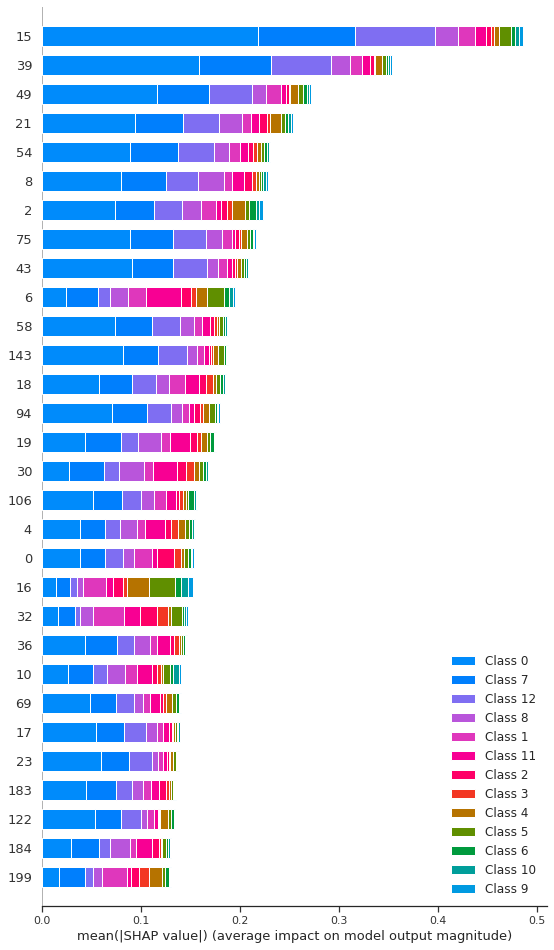

Transforming to str index.


 * Initialising ...
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_24 (Batc (None, 32)                128       
_________________________________________________________________
activation_24 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_25 (Batc (None, 16)                64        
_________________________________________________________________
activation_25 (Activation)   (Non

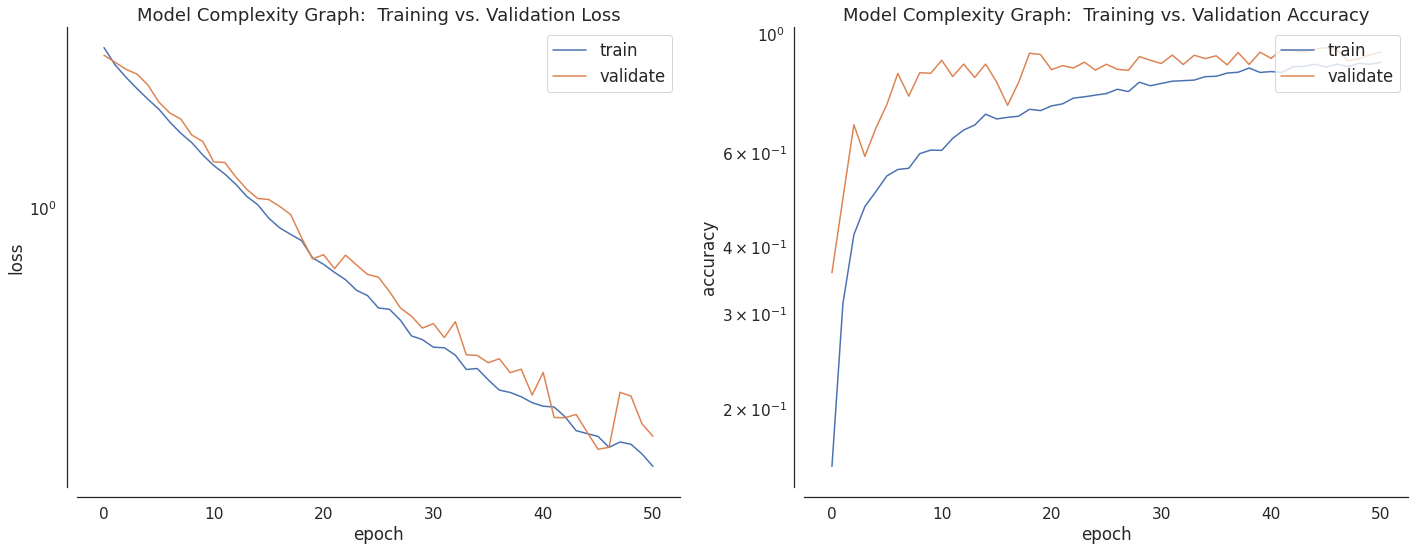

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

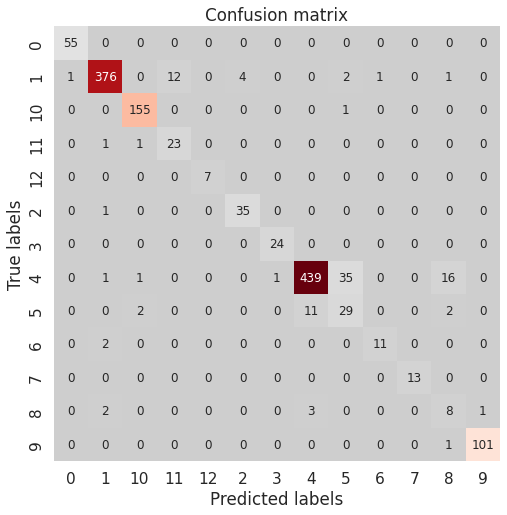

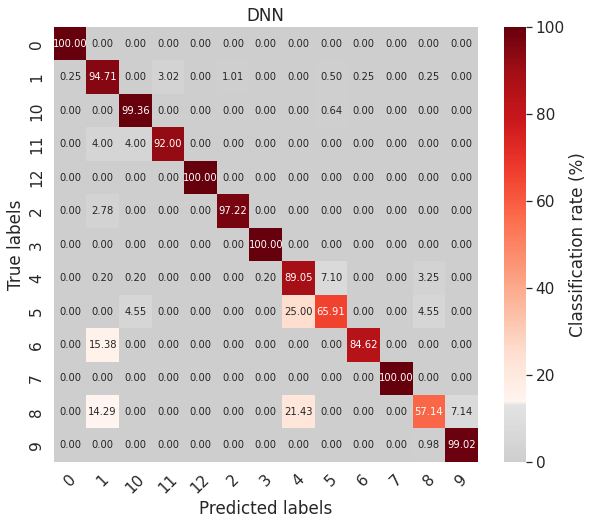

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        55
           1       0.98      0.95      0.96       397
          10       0.97      0.99      0.98       156
          11       0.66      0.92      0.77        25
          12       1.00      1.00      1.00         7
           2       0.90      0.97      0.93        36
           3       0.96      1.00      0.98        24
           4       0.97      0.89      0.93       493
           5       0.43      0.66      0.52        44
           6       0.92      0.85      0.88        13
           7       1.00      1.00      1.00        13
           8       0.29      0.57      0.38        14
           9       0.99      0.99      0.99       102

    accuracy                           0.93      1379
   macro avg       0.85      0.91      0.87      1379
weighted avg       0.94      0.93      0.93      1379

44/44 [==============================] - 0s 3ms/step - loss: 0.2645 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


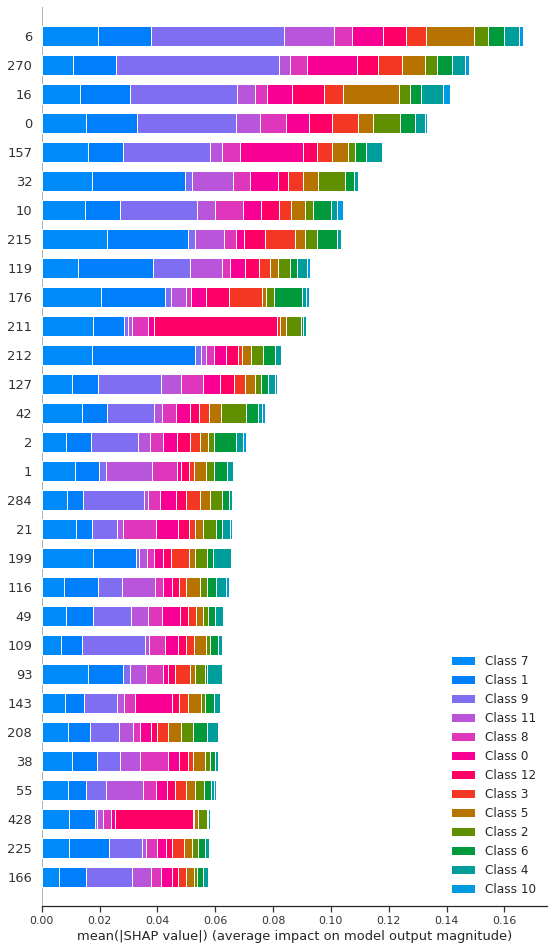

Transforming to str index.


 * Initialising ...
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_28 (Batc (None, 32)                128       
_________________________________________________________________
activation_28 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_29 (Batc (None, 16)                64        
_________________________________________________________________
activation_29 (Activation)   (Non

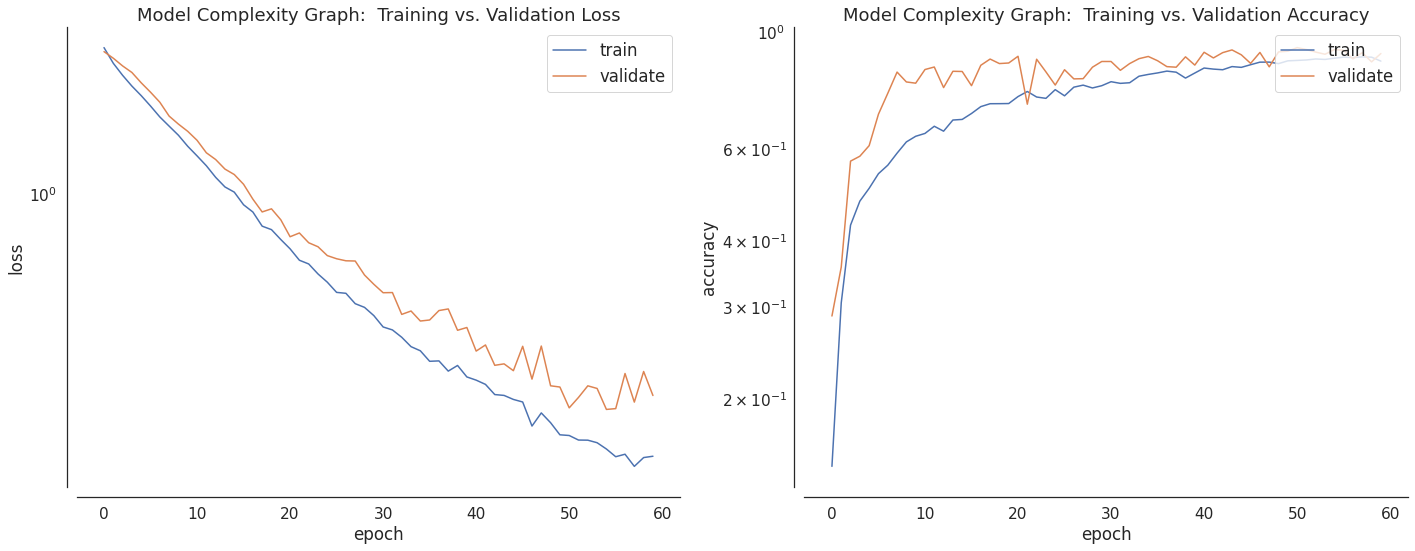

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

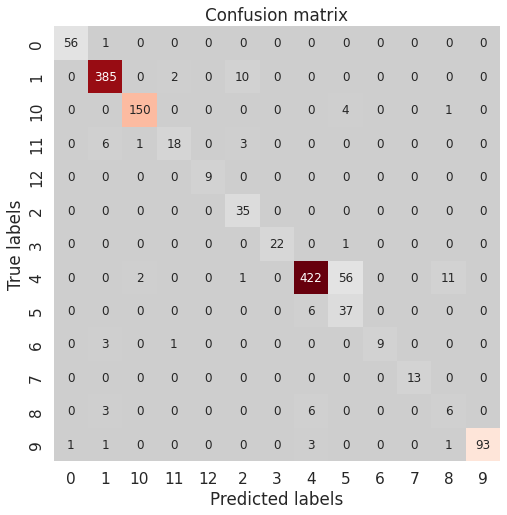

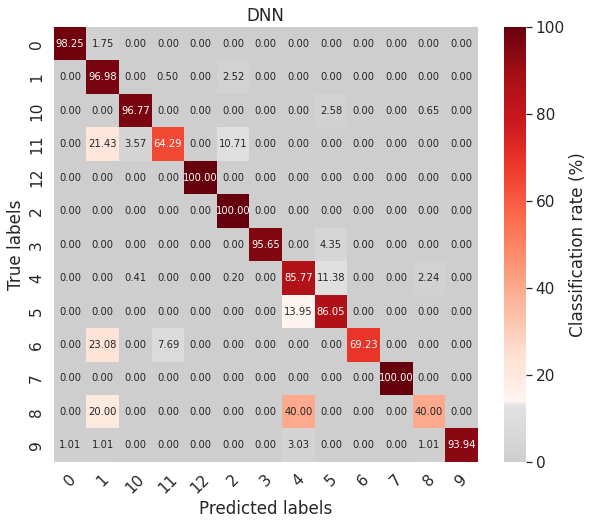

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        57
           1       0.96      0.97      0.97       397
          10       0.98      0.97      0.97       155
          11       0.86      0.64      0.73        28
          12       1.00      1.00      1.00         9
           2       0.71      1.00      0.83        35
           3       1.00      0.96      0.98        23
           4       0.97      0.86      0.91       492
           5       0.38      0.86      0.52        43
           6       1.00      0.69      0.82        13
           7       1.00      1.00      1.00        13
           8       0.32      0.40      0.35        15
           9       1.00      0.94      0.97        99

    accuracy                           0.91      1379
   macro avg       0.86      0.87      0.85      1379
weighted avg       0.94      0.91      0.92      1379

44/44 [==============================] - 0s 3ms/step - loss: 0.2757 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


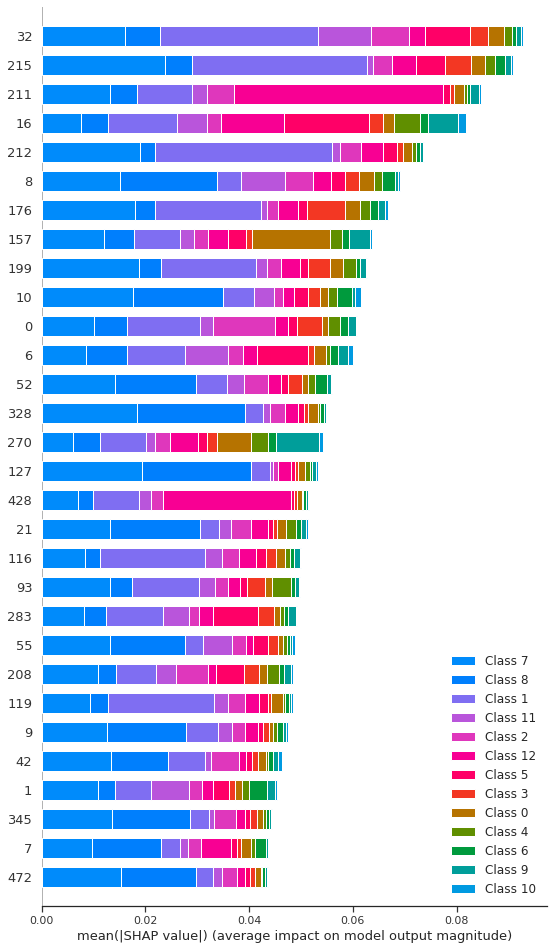

Transforming to str index.


 * Initialising ...
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_32 (Batc (None, 32)                128       
_________________________________________________________________
activation_32 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_33 (Batc (None, 16)                64        
_________________________________________________________________
activation_33 (Activation)   (Non

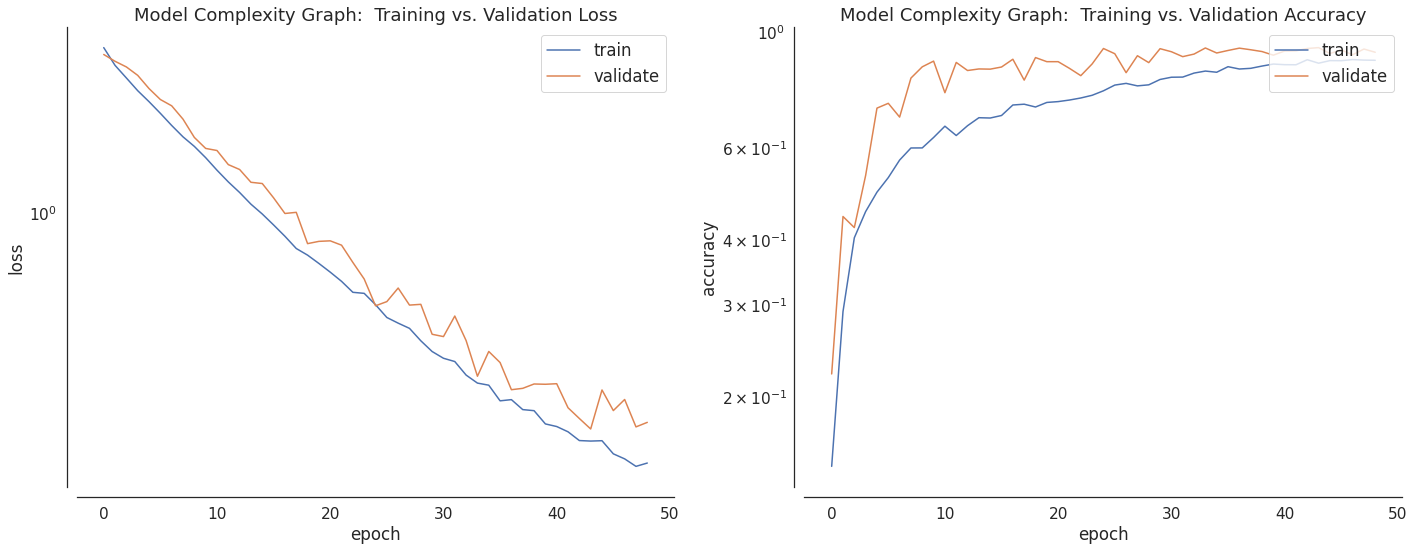

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

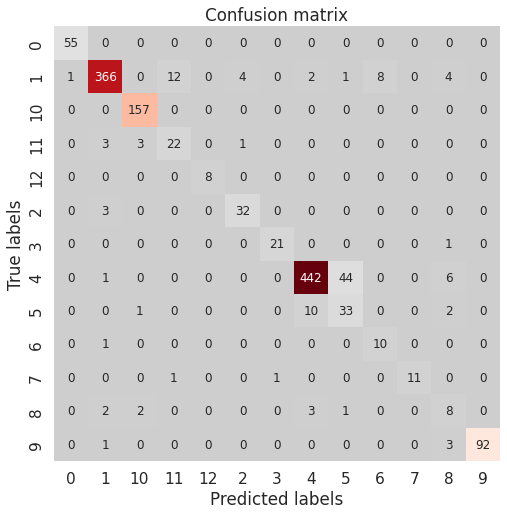

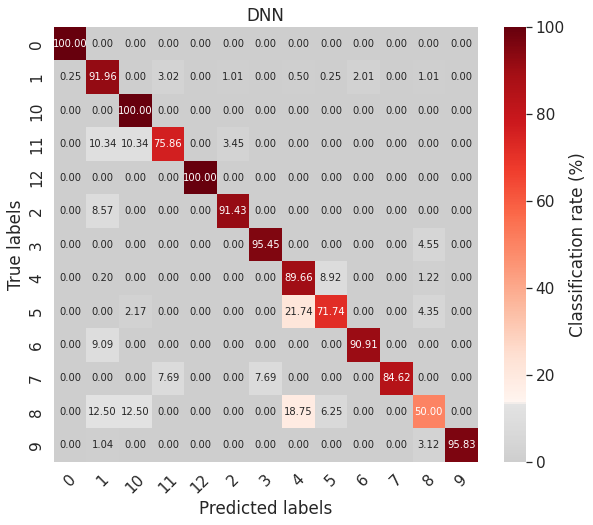

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        55
           1       0.97      0.92      0.94       398
          10       0.96      1.00      0.98       157
          11       0.63      0.76      0.69        29
          12       1.00      1.00      1.00         8
           2       0.86      0.91      0.89        35
           3       0.95      0.95      0.95        22
           4       0.97      0.90      0.93       493
           5       0.42      0.72      0.53        46
           6       0.56      0.91      0.69        11
           7       1.00      0.85      0.92        13
           8       0.33      0.50      0.40        16
           9       1.00      0.96      0.98        96

    accuracy                           0.91      1379
   macro avg       0.82      0.87      0.84      1379
weighted avg       0.93      0.91      0.92      1379

44/44 [==============================] - 0s 4ms/step - loss: 0.3140 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


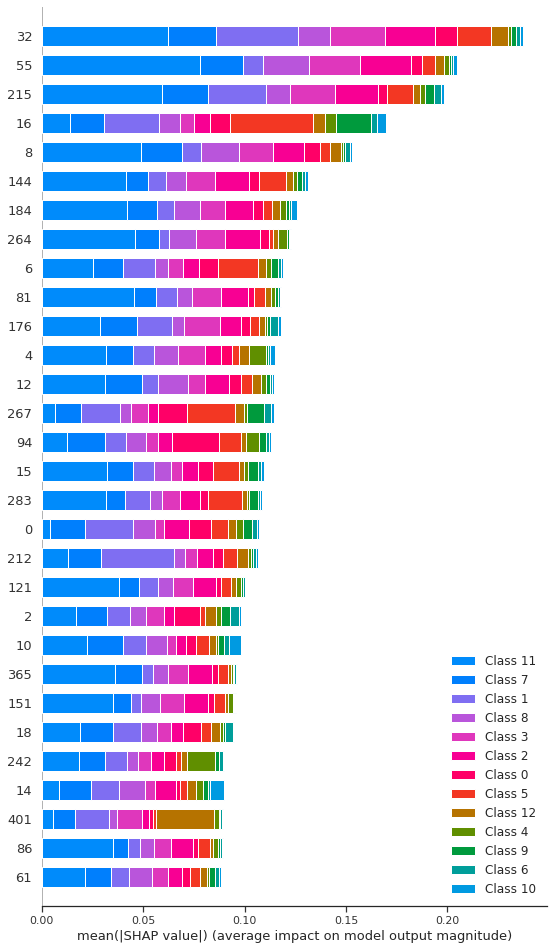

Transforming to str index.


 * Initialising ...
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_36 (Batc (None, 32)                128       
_________________________________________________________________
activation_36 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_37 (Batc (None, 16)                64        
_________________________________________________________________
activation_37 (Activation)   (Non

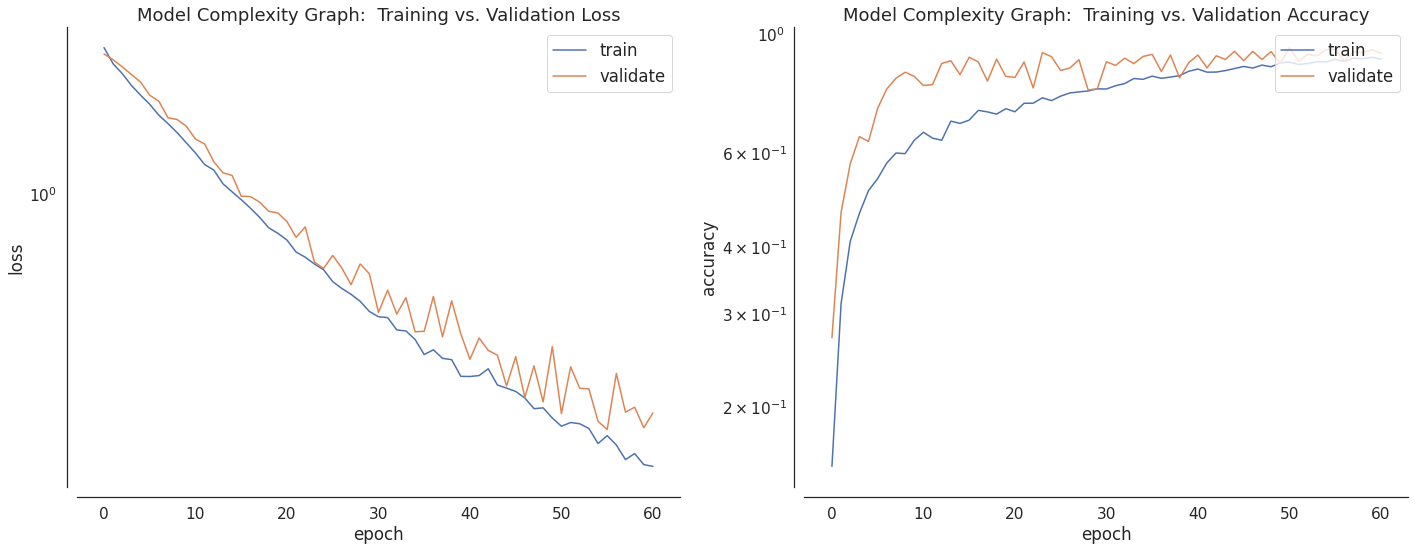

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

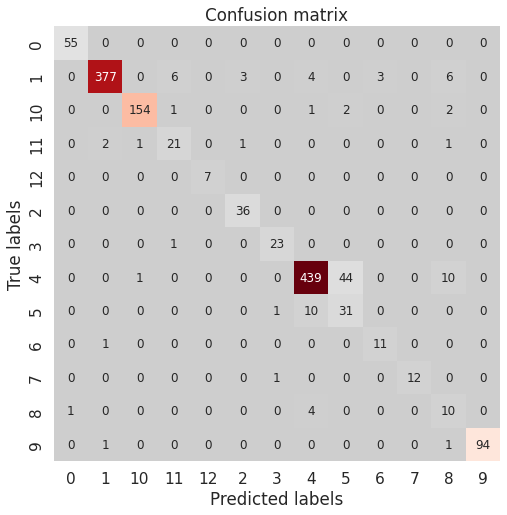

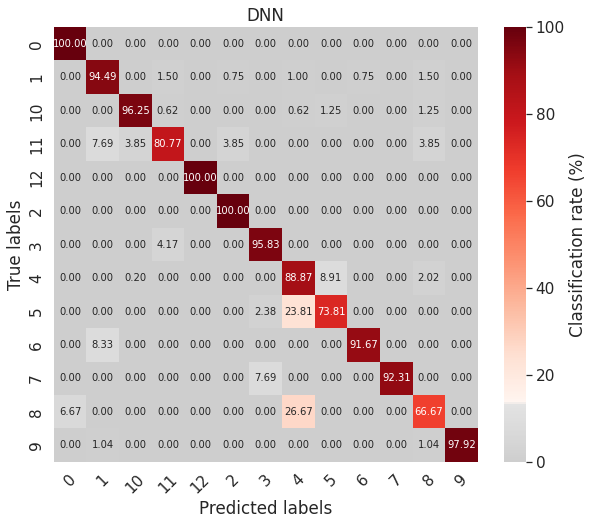

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        55
           1       0.99      0.94      0.97       399
          10       0.99      0.96      0.97       160
          11       0.72      0.81      0.76        26
          12       1.00      1.00      1.00         7
           2       0.90      1.00      0.95        36
           3       0.92      0.96      0.94        24
           4       0.96      0.89      0.92       494
           5       0.40      0.74      0.52        42
           6       0.79      0.92      0.85        12
           7       1.00      0.92      0.96        13
           8       0.33      0.67      0.44        15
           9       1.00      0.98      0.99        96

    accuracy                           0.92      1379
   macro avg       0.84      0.91      0.87      1379
weighted avg       0.94      0.92      0.93      1379

44/44 [==============================] - 0s 4ms/step - loss: 0.2377 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


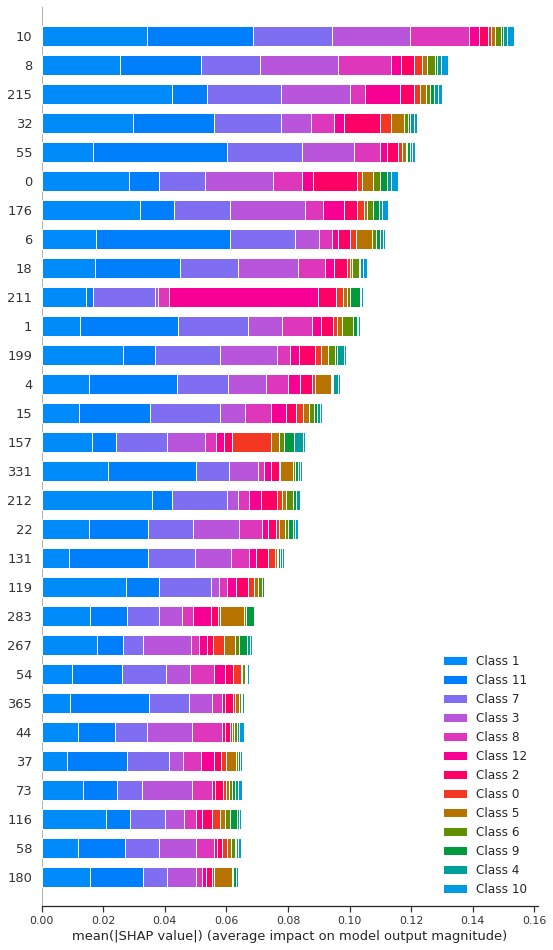

Transforming to str index.


 * Initialising ...
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_40 (Batc (None, 32)                128       
_________________________________________________________________
activation_40 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_41 (Batc (None, 16)                64        
_________________________________________________________________
activation_41 (Activation)   (Non

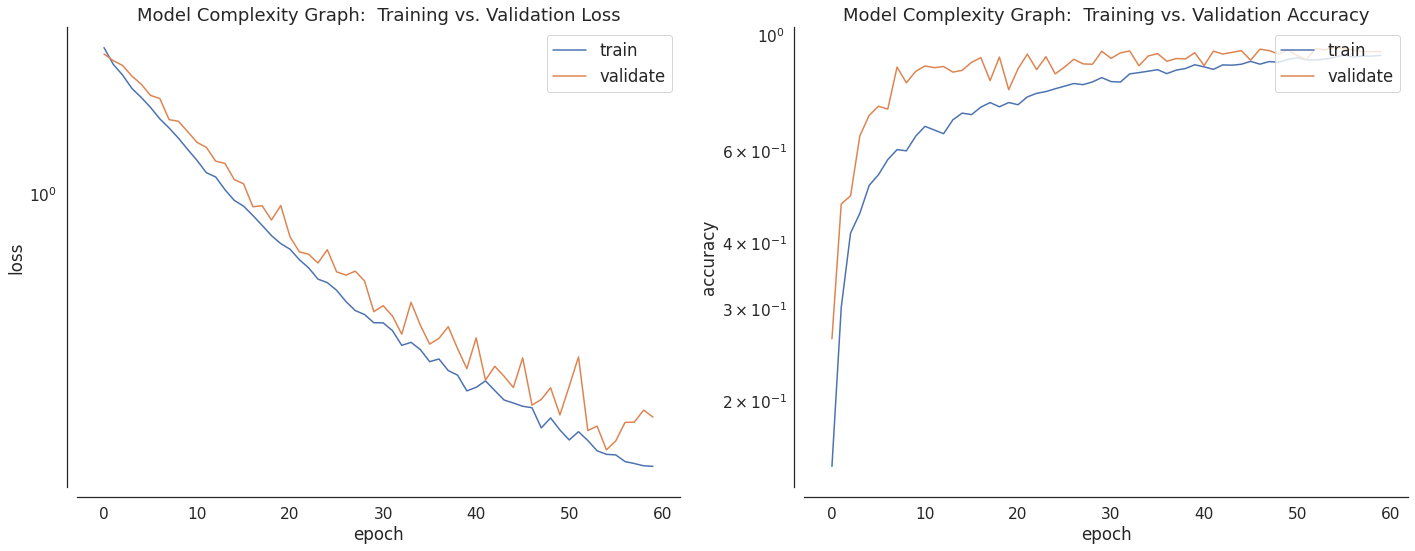

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

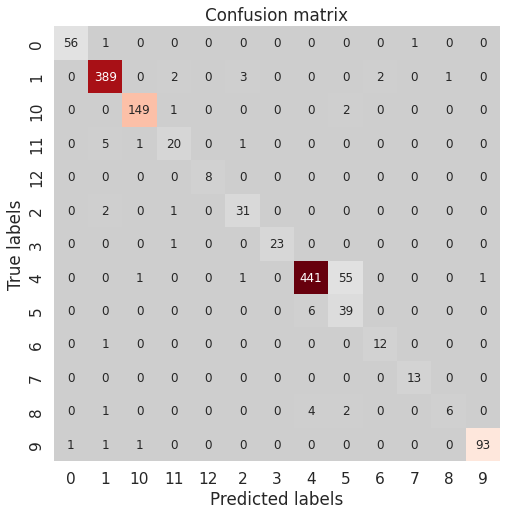

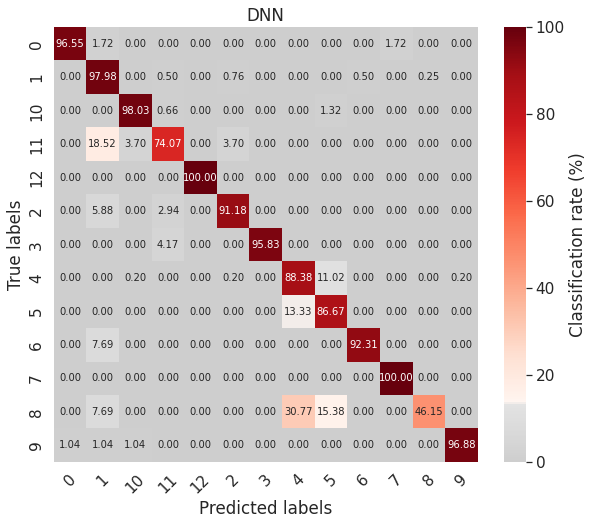

              precision    recall  f1-score   support

           0       0.98      0.97      0.97        58
           1       0.97      0.98      0.98       397
          10       0.98      0.98      0.98       152
          11       0.80      0.74      0.77        27
          12       1.00      1.00      1.00         8
           2       0.86      0.91      0.89        34
           3       1.00      0.96      0.98        24
           4       0.98      0.88      0.93       499
           5       0.40      0.87      0.55        45
           6       0.86      0.92      0.89        13
           7       0.93      1.00      0.96        13
           8       0.86      0.46      0.60        13
           9       0.99      0.97      0.98        96

    accuracy                           0.93      1379
   macro avg       0.89      0.90      0.88      1379
weighted avg       0.95      0.93      0.93      1379

44/44 [==============================] - 0s 4ms/step - loss: 0.2120 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


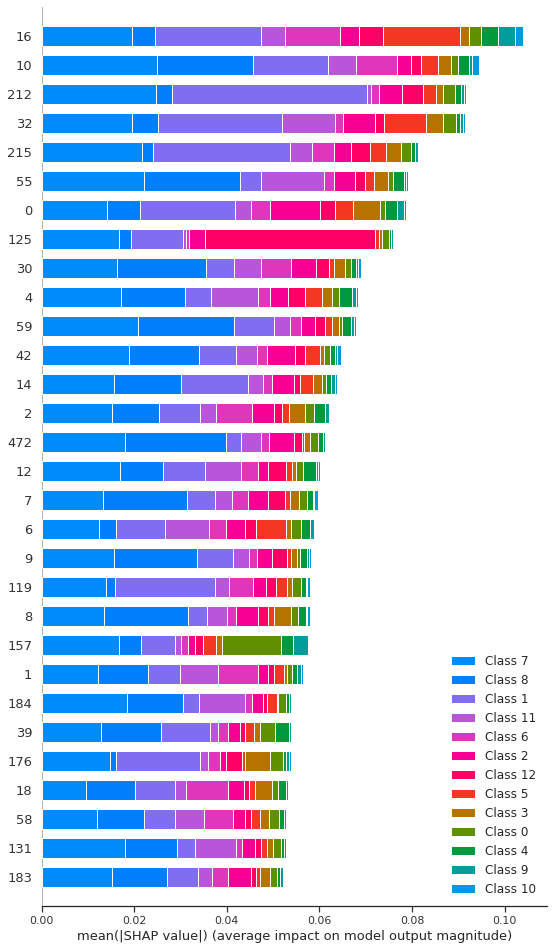

Transforming to str index.


 * Initialising ...
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_44 (Batc (None, 32)                128       
_________________________________________________________________
activation_44 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_45 (Batc (None, 16)                64        
_________________________________________________________________
activation_45 (Activation)   (Non

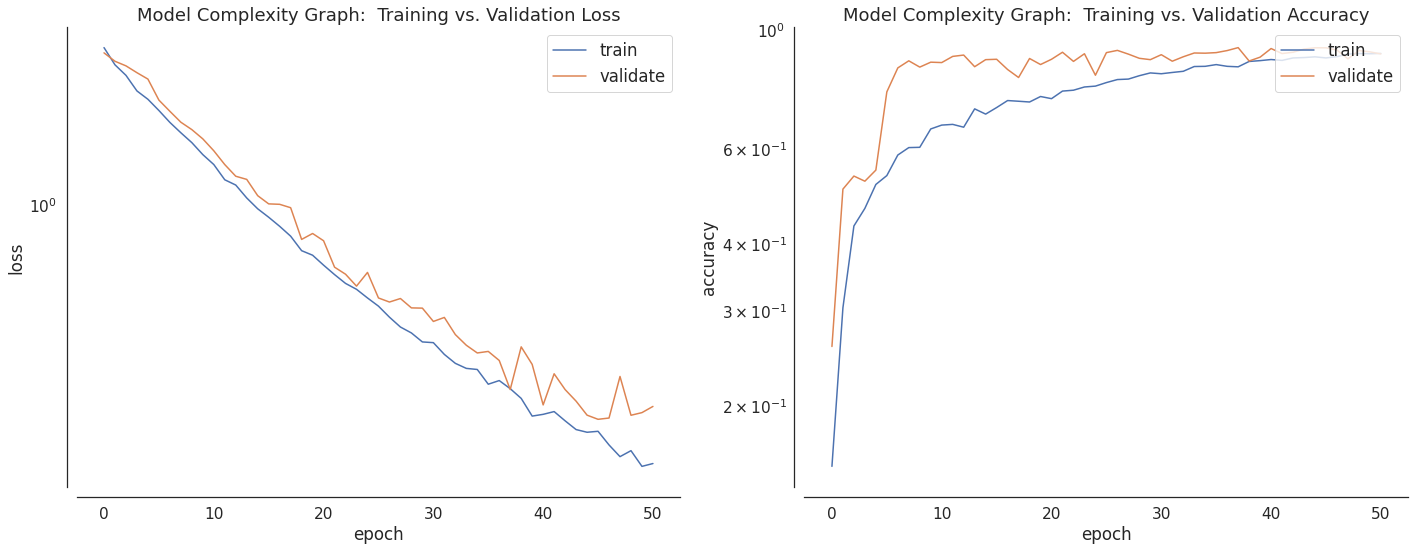

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

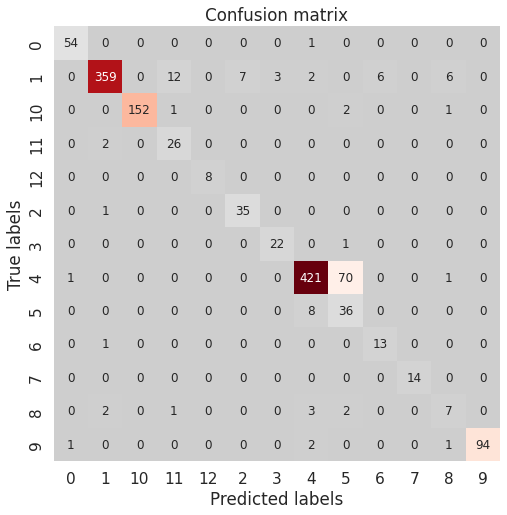

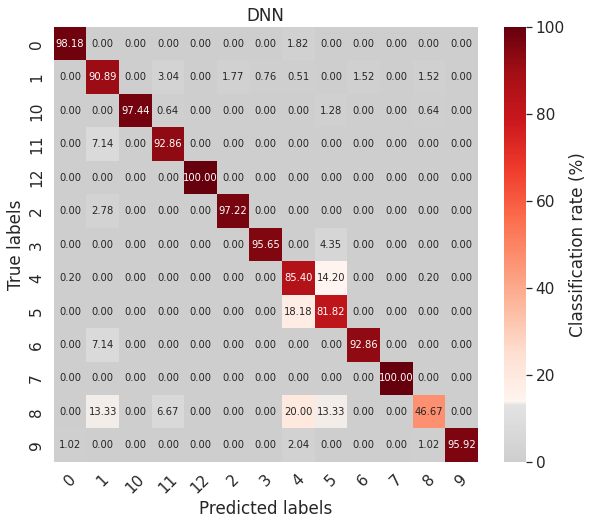

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        55
           1       0.98      0.91      0.94       395
          10       1.00      0.97      0.99       156
          11       0.65      0.93      0.76        28
          12       1.00      1.00      1.00         8
           2       0.83      0.97      0.90        36
           3       0.88      0.96      0.92        23
           4       0.96      0.85      0.91       493
           5       0.32      0.82      0.46        44
           6       0.68      0.93      0.79        14
           7       1.00      1.00      1.00        14
           8       0.44      0.47      0.45        15
           9       1.00      0.96      0.98        98

    accuracy                           0.90      1379
   macro avg       0.82      0.90      0.85      1379
weighted avg       0.94      0.90      0.91      1379

44/44 [==============================] - 0s 5ms/step - loss: 0.3000 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


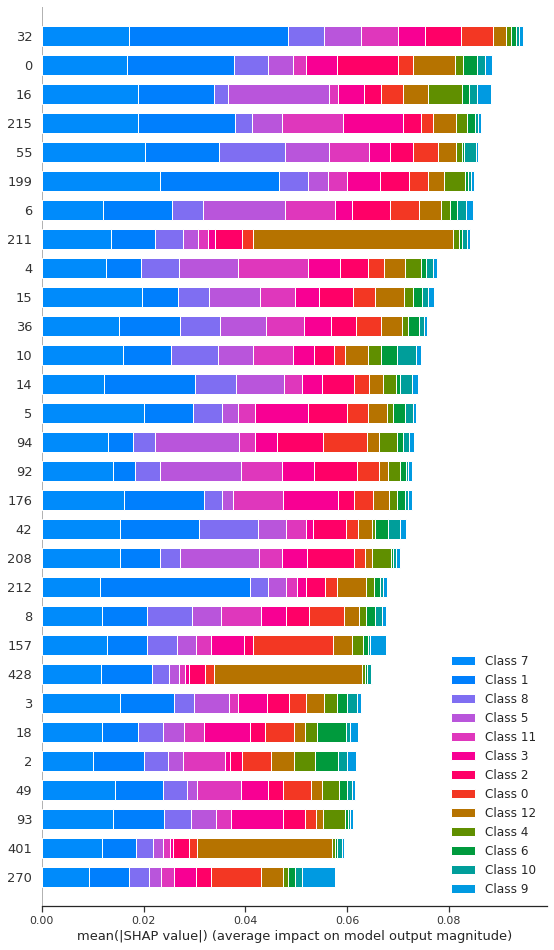

Transforming to str index.


 * Initialising ...
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_48 (Batc (None, 32)                128       
_________________________________________________________________
activation_48 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_49 (Batc (None, 16)                64        
_________________________________________________________________
activation_49 (Activation)   (Non

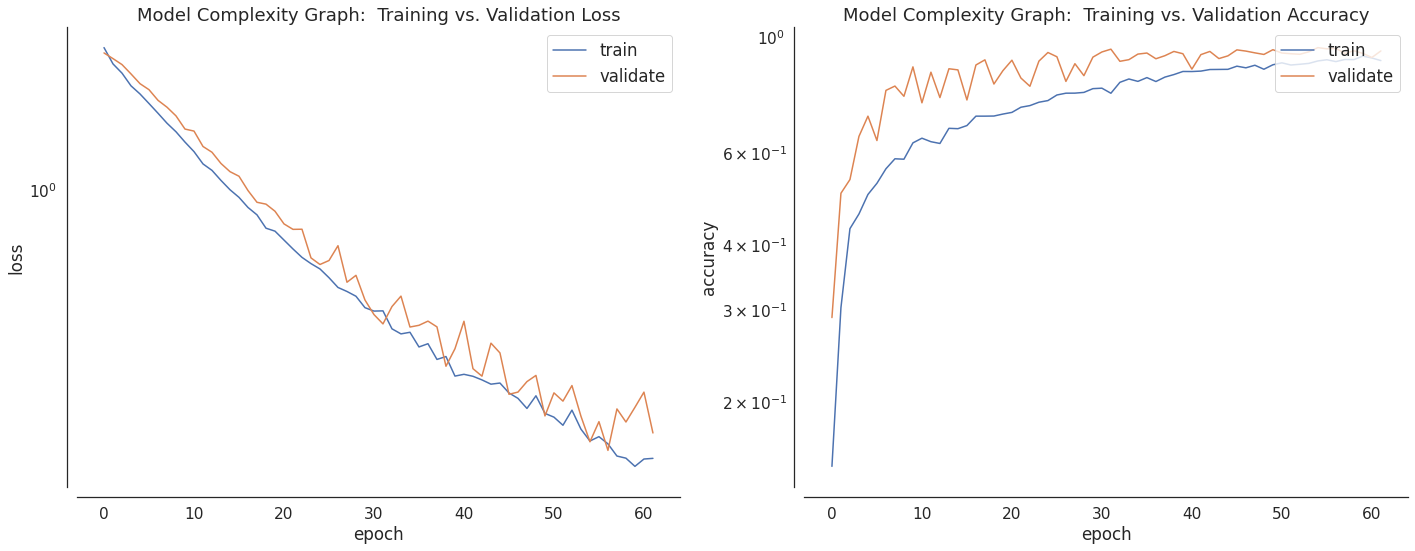

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

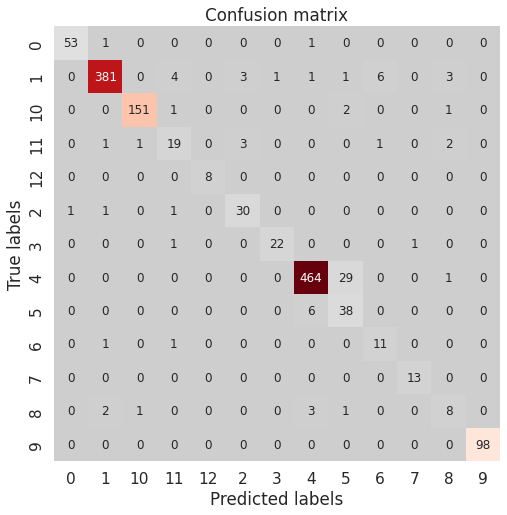

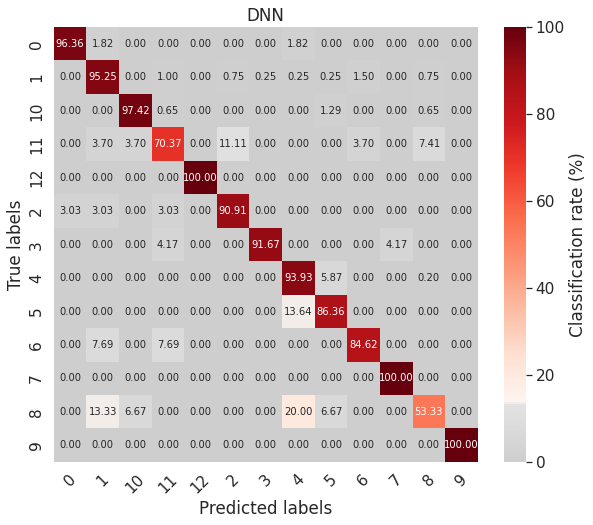

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        55
           1       0.98      0.95      0.97       400
          10       0.99      0.97      0.98       155
          11       0.70      0.70      0.70        27
          12       1.00      1.00      1.00         8
           2       0.83      0.91      0.87        33
           3       0.96      0.92      0.94        24
           4       0.98      0.94      0.96       494
           5       0.54      0.86      0.66        44
           6       0.61      0.85      0.71        13
           7       0.93      1.00      0.96        13
           8       0.53      0.53      0.53        15
           9       1.00      1.00      1.00        98

    accuracy                           0.94      1379
   macro avg       0.85      0.89      0.87      1379
weighted avg       0.95      0.94      0.94      1379

44/44 [==============================] - 0s 5ms/step - loss: 0.1986 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


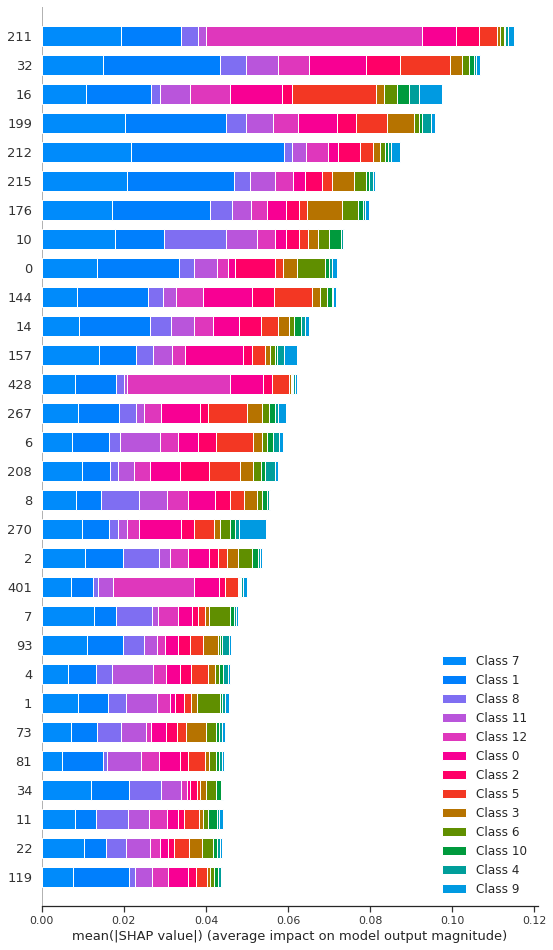

Transforming to str index.


 * Initialising ...
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_52 (Batc (None, 32)                128       
_________________________________________________________________
activation_52 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_53 (Batc (None, 16)                64        
_________________________________________________________________
activation_53 (Activation)   (Non

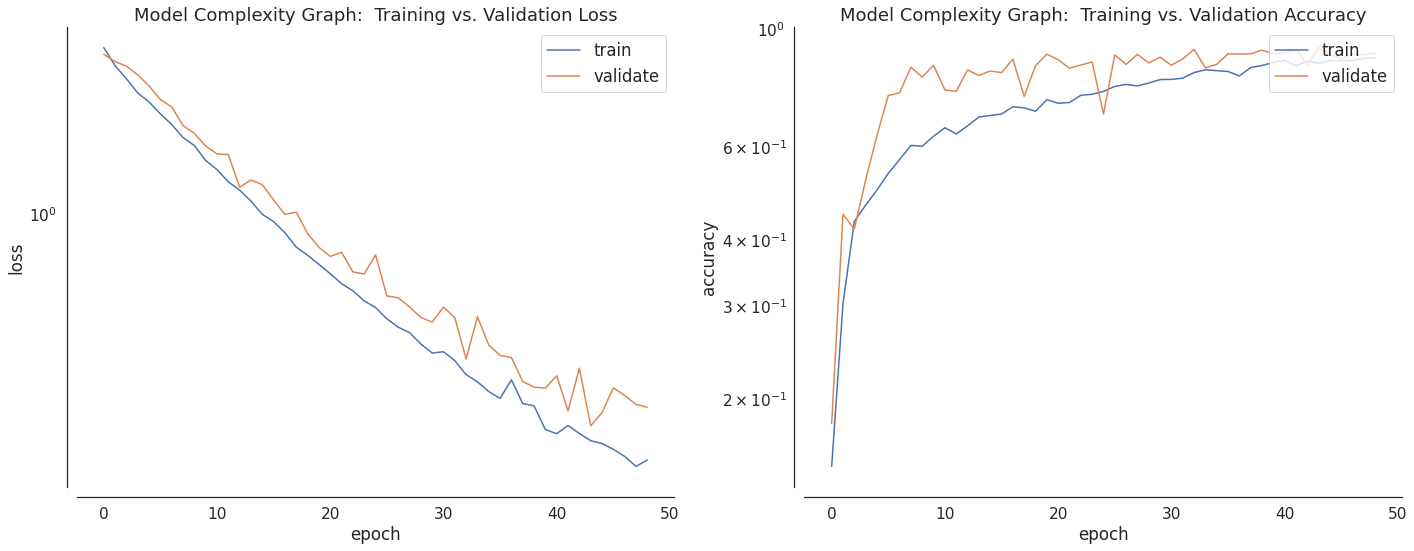

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

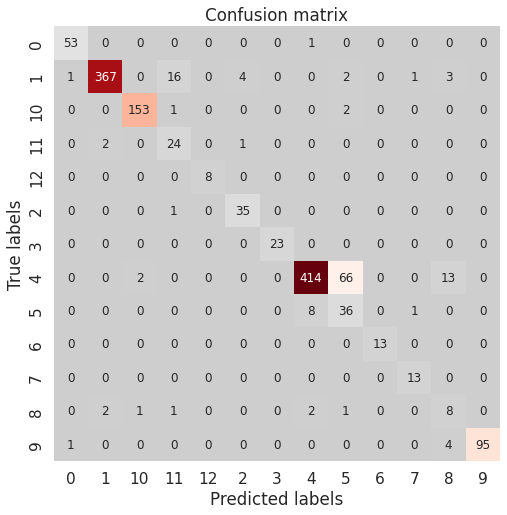

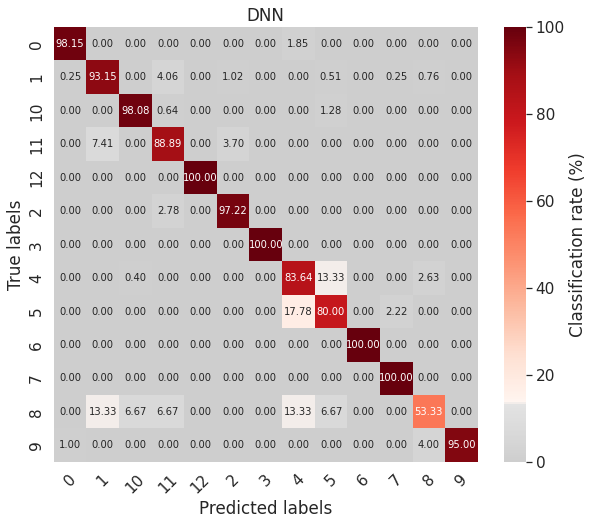

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        54
           1       0.99      0.93      0.96       394
          10       0.98      0.98      0.98       156
          11       0.56      0.89      0.69        27
          12       1.00      1.00      1.00         8
           2       0.88      0.97      0.92        36
           3       1.00      1.00      1.00        23
           4       0.97      0.84      0.90       495
           5       0.34      0.80      0.47        45
           6       1.00      1.00      1.00        13
           7       0.87      1.00      0.93        13
           8       0.29      0.53      0.37        15
           9       1.00      0.95      0.97       100

    accuracy                           0.90      1379
   macro avg       0.83      0.91      0.86      1379
weighted avg       0.94      0.90      0.91      1379

44/44 [==============================] - 0s 5ms/step - loss: 0.3238 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [ ]:
%%time
k = 50
for tryy in range(1,num_times+1):
    # The smashpy methods set global seeds that mess with sampling. These seeds are used 
    # to stop those methods from using the same global seed over and over.
    np.random.seed(possible_seeds[seed_index])
    seed_index += 1
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = SmashPyWrapper.prepareData(X, y, train_indices, val_indices, 'annotation')
    sm = smashpy.smashpy()
    sm.DNN(train_X_y, group_by="annotation", model=None, balance=True, verbose=True, save=False)
    selectedGenes, selectedGenes_dict = sm.run_shap(train_X_y, group_by="annotation", model=None, verbose=True, pct=0.1, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = train_X_y.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    plot_umap_embedding(X, y, encoder, 'Smash Marker Visualization', path = viz_save_path + 'smash_markers_{}.png'.format(tryy), markers = smash_markers, close_fig = True)

In [ ]:
# The smashpy methods set global seeds that mess with sampling. These seeds are used 
# to stop those methods from using the same global seed over and over.
np.random.seed(possible_seeds[seed_index])
seed_index += 1

## Train RankCorr

In [ ]:
lamb_range = [0.5, 1.5, 3, 7, 21.9]
lamb_i = 0

In [ ]:
for k in k_range:
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    data = RankCorrWrapper(X_train, y_train)
    lamb = lamb_range[lamb_i]
    lamb_i = lamb_i + 1

    rankcorr_markers = data.CSrankMarkers(lamb=lamb, writeOut=False, keepZeros=False, onlyNonZero=False)
    if len(rankcorr_markers) < k:
        print(lamb)
        print(len(rankcorr_markers))
        print(k)
        raise Exception("Increase lamb for rank corr procedure")
    if len(rankcorr_markers) > k:
        #print("Excess Length of markers")
        #print(len(rankcorr_markers))
        rankcorr_markers = rankcorr_markers[:k]
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = rankcorr_markers)
    np.save(model_save_path + 'rankcorr_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'rankcorr_markers_k_{}.npy'.format(k), rankcorr_markers)
    np.save(model_save_path + 'experiment_data_folds/rankcorr_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    plot_umap_embedding(X, y, encoder, 'RankCorr Marker Visualization', path = viz_save_path + 'rankcorr_markers_k_{}.png'.format(k), markers = rankcorr_markers, close_fig = True)

In [ ]:
k = 50
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    data = RankCorrWrapper(X_train, y_train)
    lamb = 3.2# this can be whatever

    rankcorr_markers = data.CSrankMarkers(lamb=lamb, writeOut=False, keepZeros=False, onlyNonZero=False)
    if len(rankcorr_markers) < k:
        raise Exception("Increase lamb for rank corr procedure")
    if len(rankcorr_markers) > k:
        #print("Excess Length of markers")
        #print(len(rankcorr_markers))
        rankcorr_markers = rankcorr_markers[:k]
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = rankcorr_markers)
    np.save(model_save_path + 'rankcorr_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'rankcorr_markers_{}.npy'.format(tryy), rankcorr_markers)
    np.save(model_save_path + 'experiment_data_folds/rankcorr_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    plot_umap_embedding(X, y, encoder, 'RankCorr Marker Visualization', path = viz_save_path + 'rankcorr_markers_{}.png'.format(tryy), markers = rankcorr_markers, close_fig = True)

## Train L1 VAE

In [ ]:
feature_std = torch.tensor(X).std(dim = 0)
for k in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_l1_diag(input_size, hidden_layer_size, z_size, batch_norm = batch_norm)
    tmp_path = model_save_path + 'l1_vae_k_{}.ckpt'.format(k)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, min_epochs = 25, 
                     max_epochs = 100, auto_lr = True, early_stopping_patience = 4, precision = precision)
    l1_markers = model.markers(feature_std = feature_std.to(model.device), k = k).clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = l1_markers)
    np.save(model_save_path + 'l1_vae_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'l1_vae_markers_k_{}.npy'.format(k), l1_markers)
    np.save(model_save_path + 'experiment_data_folds/l1_vae_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    plot_umap_embedding(X, y, encoder, 'L1 VAE Marker Visualization', path = viz_save_path + 'l1_vae_markers_k_{}.png'.format(k), markers = l1_markers, close_fig = True)

In [ ]:
feature_std = torch.tensor(X).std(dim = 0)
k = 50
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_l1_diag(input_size, hidden_layer_size, z_size, batch_norm = batch_norm)
    tmp_path = model_save_path + 'l1_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, min_epochs = 25, 
                     max_epochs = 100, auto_lr = True, early_stopping_patience = 4, precision = precision)
    l1_markers = model.markers(feature_std = feature_std.to(model.device), k = k).clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = l1_markers)
    np.save(model_save_path + 'l1_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'l1_vae_markers_{}.npy'.format(tryy), l1_markers)
    np.save(model_save_path + 'experiment_data_folds/l1_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    plot_umap_embedding(X, y, encoder, 'L1 VAE Marker Visualization', path = viz_save_path + 'l1_vae_markers_{}.png'.format(tryy), markers = l1_markers, close_fig = True)

## Train Global Gate

In [ ]:
for k in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers=num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_Gumbel_GlobalGate(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'globalgate_vae_k_{}.ckpt'.format(k)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus = gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.00001, early_stopping_patience =  10, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    globalgate_markers = model.markers().clone().cpu().detach().numpy()
    
 
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = globalgate_markers)
    np.save(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'globalgate_vae_markers_k_{}.npy'.format(k), globalgate_markers)
    np.save(model_save_path + 'experiment_data_folds/globalgate_vae_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    plot_umap_embedding(X, y, encoder, 'Global Gate VAE Marker Visualization', path = viz_save_path + 'globalgate_vae_markers_k_{}.png'.format(k), markers = globalgate_markers, close_fig = True)

In [ ]:
k = 50
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers=num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_Gumbel_GlobalGate(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'globalgate_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus = gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.00001, early_stopping_patience =  10, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    globalgate_markers = model.markers().clone().cpu().detach().numpy()
    
 
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = globalgate_markers)
    np.save(model_save_path + 'globalgate_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'globalgate_vae_markers_{}.npy'.format(tryy), globalgate_markers)
    np.save(model_save_path + 'experiment_data_folds/globalgate_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    plot_umap_embedding(X, y, encoder, 'Global Gate VAE Marker Visualization', path = viz_save_path + 'globalgate_vae_markers_{}.png'.format(tryy), markers = globalgate_markers, close_fig = True)

## Train MarkerMap Unsupervised

In [ ]:
for k in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = MarkerMap(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 1.0, num_classes = None)
    tmp_path = model_save_path + 'marker_map_unsupervised_k_{}.ckpt'.format(k)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 4, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    marker_map_unsupervised_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = marker_map_unsupervised_markers)
    np.save(model_save_path + 'marker_map_unsupervised_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'marker_map_unsupervised_markers_k_{}.npy'.format(k), marker_map_unsupervised_markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    plot_umap_embedding(X, y, encoder, 'MarkerMap Unsupervised Marker Visualization', path = viz_save_path + 'marker_map_unsupervised_markers_k_{}.png'.format(k), markers = marker_map_unsupervised_markers, close_fig = True)

In [ ]:
k = 50
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = MarkerMap(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 1.0, num_classes = None)
    tmp_path = model_save_path + 'marker_map_unsupervised_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 4, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    unsupervised_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = unsupervised_markers)
    np.save(model_save_path + 'marker_map_unsupervised_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), unsupervised_markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    plot_umap_embedding(X, y, encoder, 'Marker Map Unsupervised Marker Visualization', path = viz_save_path + 'marker_map_unsupervised_markers_{}.png'.format(tryy), markers = unsupervised_markers, close_fig = True)

## MarkerMap Supervised

In [ ]:
for k in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0)
    tmp_path = model_save_path + 'marker_map_supervised_k_{}.ckpt'.format(k)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_supervised_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'marker_map_supervised_markers_k_{}.npy'.format(k), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    plot_umap_embedding(X, y, encoder, 'MarkerMap Supervised Marker Visualization', path = viz_save_path + 'marker_map_supervised_markers_k_{}.png'.format(k), markers = markers, close_fig = True)

In [ ]:
k = 50
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0)
    tmp_path = model_save_path + 'marker_map_supervised_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_supervised_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_supervised_markers_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    plot_umap_embedding(X, y, encoder, 'MarkerMap Supervised Marker Visualization', path = viz_save_path + 'marker_map_supervised_markers_{}.png'.format(tryy), markers = markers, close_fig = True)

## Train MarkerMap Mixed Supervision

In [32]:
for tryy in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
            k = tryy, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0.5)
    tmp_path = model_save_path + 'marker_map_mixed_k_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_mixed_results_k_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_mixed_markers_k_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_mixed_indices_k_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    plot_umap_embedding(X, y, encoder, 'MarkerMap Mixed Supervision Marker Visualization', path = viz_save_path + 'marker_map_mixed_markers_k_{}.png'.format(tryy), markers = markers, close_fig = True)

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

In [30]:
k = 50
tryy = 1
# for tryy in range(1,num_times+1):
train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
X_train = X[np.concatenate([train_indices, val_indices]), :]
y_train = y[np.concatenate([train_indices, val_indices])]
X_test = X[test_indices,:]
y_test = y[test_indices]

model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                            k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0.5)
tmp_path = model_save_path + 'marker_map_mixed_{}.ckpt'.format(tryy)
# DO NOT USE IN OTHER WORKLOADS
train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                    min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
markers = model.markers().clone().cpu().detach().numpy()


results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
np.save(model_save_path + 'marker_map_mixed_results_{}.npy'.format(tryy), results)
np.save(model_save_path + 'marker_map_mixed_markers_{}.npy'.format(tryy), markers)
np.save(model_save_path + 'experiment_data_folds/marker_map_mixed_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

plot_umap_embedding(X, y, encoder, 'MarkerMap Mixed Supervision Marker Visualization', path = viz_save_path + 'marker_map_mixed_markers_{}.png'.format(tryy), markers = markers, close_fig = True)

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

## Concrete VAE

In [ ]:
for k in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = ConcreteVAE_NMSL(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay = 0.9, batch_norm = batch_norm)
    tmp_path = model_save_path + 'concrete_vae_k_{}.ckpt'.format(k)
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=0, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 3, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = 16)
    concrete_vae_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = concrete_vae_markers)
    np.save(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'concrete_vae_markers_k_{}.npy'.format(k), concrete_vae_markers)
    np.save(model_save_path + 'experiment_data_folds/concrete_vae_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    plot_umap_embedding(X, y, encoder, 'Concrete VAE Marker Visualization', path = viz_save_path + 'concrete_vae_markers_k_{}.png'.format(k), markers = concrete_vae_markers, close_fig = True)

In [ ]:
k = 50
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = ConcreteVAE_NMSL(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay = 0.9, batch_norm = batch_norm)
    tmp_path = model_save_path + 'concrete_vae_{}.ckpt'.format(tryy)
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 3, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    concrete_vae_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = concrete_vae_markers)
    np.save(model_save_path + 'concrete_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'concrete_vae_markers_{}.npy'.format(tryy), concrete_vae_markers)
    np.save(model_save_path + 'experiment_data_folds/concrete_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    plot_umap_embedding(X, y, encoder, 'Concrete VAE Marker Visualization', path = viz_save_path + 'concrete_vae_markers_{}.png'.format(tryy), markers = concrete_vae_markers, close_fig = True)

## LassoNet

In [17]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [10]:
from functools import partial
from lassonet import plot_path

In [11]:
k = 50
for tryy in range(1,num_times+1):  
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[train_indices, :]
    y_train = y[train_indices]
    X_val = X[val_indices,:]
    y_val = y[val_indices]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = LassoNetClassifier(hidden_dims = (hidden_layer_size, hidden_layer_size, hidden_layer_size))
    model.path(X_train, y_train, X_val = X_val, y_val = y_val)
    lasso_net_markers = torch.argsort(model.feature_importances_, descending = True).cpu().numpy()[:k]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = lasso_net_markers)
    np.save(model_save_path + 'lasso_net_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'lasso_net_markers_{}.npy'.format(tryy), lasso_net_markers)
    np.save(model_save_path + 'experiment_data_folds/lasso_net_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    plot_umap_embedding(X, y, encoder, 'LassoNet Marker Visualization', path = viz_save_path + 'lasso_net_markers_{}.png'.format(tryy), markers = lasso_net_markers, close_fig = True)

KeyboardInterrupt: ignored

In [15]:
for k in k_range:
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[train_indices, :]
    y_train = y[train_indices]
    X_val = X[val_indices,:]
    y_val = y[val_indices]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = LassoNetClassifier(hidden_dims = (hidden_layer_size, hidden_layer_size, hidden_layer_size))
    model.path(X_train, y_train, X_val = X_val, y_val = y_val)
    lasso_net_markers = torch.argsort(model.feature_importances_, descending = True).cpu().numpy()[:k]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = lasso_net_markers)
    np.save(model_save_path + 'lasso_net_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'lasso_net_markers_k_{}.npy'.format(k), lasso_net_markers)
    np.save(model_save_path + 'experiment_data_folds/lasso_net_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))
    plot_umap_embedding(X, y, encoder, 'LassoNet Marker Visualization', path = viz_save_path + 'lasso_net_markers_k_{}.png'.format(k), markers = lasso_net_markers, close_fig = True)

KeyboardInterrupt: ignored

## Get Model Metrics from KNNs Classifiers


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
def generate_metrics_from_saved_files(X, y, folds_path, markers_path, classifier_model, save_path):
    train_indices, val_indices, test_indices = np.load(folds_path, allow_pickle = True)
    markers = np.load(markers_path, allow_pickle = True)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices, :]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers, model = classifier_model)

    np.save(save_path, results)
    return

In [ ]:
def batch_generate_metrics_from_saved_files(X, y, format_folds_path, format_markers_path, format_save_path):
    for tryy in range(1, num_times+1):
        classifier_model = KNeighborsClassifier()
        generate_metrics_from_saved_files(X, y, format_folds_path.format(tryy), format_markers_path.format(tryy), classifier_model, format_save_path.format(tryy))
    return

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/all_markers_indices_{}.npy',
                                  model_save_path+'all_markers_{}.npy',
                                  model_save_path+'all_markers_knn_results_{}.npy')

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/l1_vae_indices_{}.npy',
                                  model_save_path+'l1_vae_markers_{}.npy',
                                  model_save_path+'l1_vae_knn_results_{}.npy')

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_rf_indices_{}.npy',
                                  model_save_path+'smash_rf_markers_{}.npy',
                                  model_save_path+'smash_rf_knn_results_{}.npy')

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_indices_{}.npy',
                                  model_save_path+'smash_markers_{}.npy',
                                  model_save_path+'smash_knn_results_{}.npy')

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/rankcorr_indices_{}.npy',
                                  model_save_path+'rankcorr_markers_{}.npy',
                                  model_save_path+'rankcorr_knn_results_{}.npy')

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/globalgate_vae_indices_{}.npy',
                                  model_save_path+'globalgate_vae_markers_{}.npy',
                                  model_save_path+'globalgate_vae_knn_results_{}.npy')

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_unsupervised_indices_{}.npy',
                                  model_save_path+'marker_map_unsupervised_markers_{}.npy',
                                  model_save_path+'marker_map_unsupervised_knn_results_{}.npy')

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_supervised_indices_{}.npy',
                                  model_save_path+'marker_map_supervised_markers_{}.npy',
                                  model_save_path+'marker_map_supervised_knn_results_{}.npy')

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_mixed_indices_{}.npy',
                                  model_save_path+'marker_map_mixed_markers_{}.npy',
                                  model_save_path+'marker_map_mixed_knn_results_{}.npy')

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/concrete_vae_indices_{}.npy',
                                  model_save_path+'concrete_vae_markers_{}.npy',
                                  model_save_path+'concrete_vae_knn_results_{}.npy')

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/lasso_net_indices_{}.npy',
                                  model_save_path+'lasso_net_markers_{}.npy',
                                  model_save_path+'lasso_net_knn_results_{}.npy')

### Generate the same metrics using the various K ranges instead

In [ ]:
# for looking at things that did one trial
def batch_generate_metrics_from_saved_files_limited(X, y, format_folds_path, format_markers_path, format_save_path):
    for k in k_range:
        classifier_model = KNeighborsClassifier()
        generate_metrics_from_saved_files(X, y, format_folds_path.format(k), format_markers_path.format(k), classifier_model, format_save_path.format(k))
    return

In [ ]:
batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/l1_vae_indices_k_{}.npy',
                                  model_save_path+'l1_vae_markers_k_{}.npy',
                                  model_save_path+'l1_vae_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/smash_rf_indices_k_{}.npy',
                                  model_save_path+'smash_rf_markers_k_{}.npy',
                                  model_save_path+'smash_rf_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/smash_indices_k_{}.npy',
                                  model_save_path+'smash_markers_k_{}.npy',
                                  model_save_path+'smash_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/rankcorr_indices_k_{}.npy',
                                  model_save_path+'rankcorr_markers_k_{}.npy',
                                  model_save_path+'rankcorr_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/globalgate_vae_indices_k_{}.npy',
                                  model_save_path+'globalgate_vae_markers_k_{}.npy',
                                  model_save_path+'globalgate_vae_knn_results_k_{}.npy')


batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_unsupervised_indices_k_{}.npy',
                                  model_save_path+'marker_map_unsupervised_markers_k_{}.npy',
                                  model_save_path+'marker_map_unsupervised_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_supervised_indices_k_{}.npy',
                                  model_save_path+'marker_map_supervised_markers_k_{}.npy',
                                  model_save_path+'marker_map_supervised_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_mixed_indices_k_{}.npy',
                                  model_save_path+'marker_map_mixed_markers_k_{}.npy',
                                  model_save_path+'marker_map_mixed_knn_results_k_{}.npy')


batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/concrete_vae_indices_k_{}.npy',
                                  model_save_path+'concrete_vae_markers_k_{}.npy',
                                  model_save_path+'concrete_vae_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/lasso_net_indices_k_{}.npy',
                                  model_save_path+'lasso_net_markers_k_{}.npy',
                                  model_save_path+'lasso_net_knn_results_k_{}.npy')

# Results and Visualizations

In [ ]:
k = 50

## Accuracies and F1

In [ ]:
result_axis = [
 ('All Markers', 'all_markers_results_{}.npy', 'all_markers_knn_results_{}.npy'), 
 ('L1 VAE', 'l1_vae_results_{}.npy', 'l1_vae_knn_results_{}.npy'),
 ('Smash RF', 'smash_rf_results_{}.npy', 'smash_rf_knn_results_{}.npy'),
 ('SMaSH DNN', 'smash_results_{}.npy', 'smash_knn_results_{}.npy'),
 ('RankCorr', 'rankcorr_results_{}.npy', 'rankcorr_knn_results_{}.npy'),
 ('Global Gate VAE', 'globalgate_vae_results_{}.npy', 'globalgate_vae_knn_results_{}.npy'),
 ('MarkerMap Unsupervised', 'marker_map_unsupervised_results_{}.npy', 'marker_map_unsupervised_knn_results_{}.npy'),
 ('MarkerMap Supervised', 'marker_map_supervised_results_{}.npy', 'marker_map_supervised_knn_results_{}.npy'),
 ('MarkerMap Mixed Supervision', 'marker_map_mixed_results_{}.npy', 'marker_map_mixed_knn_results_{}.npy'),
 ('Concrete VAE',  'concrete_vae_results_{}.npy', 'concrete_vae_knn_results_{}.npy'),
 ('LassoNet', 'lasso_net_results_{}.npy', 'lasso_net_knn_results_{}.npy')
]

In [ ]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[1], num_times))
    indices.append(axis[0])

In [ ]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

In [ ]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[2], num_times))
    indices.append(axis[0])

In [ ]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

## Confusion Matrices

k = 50

### All Markers

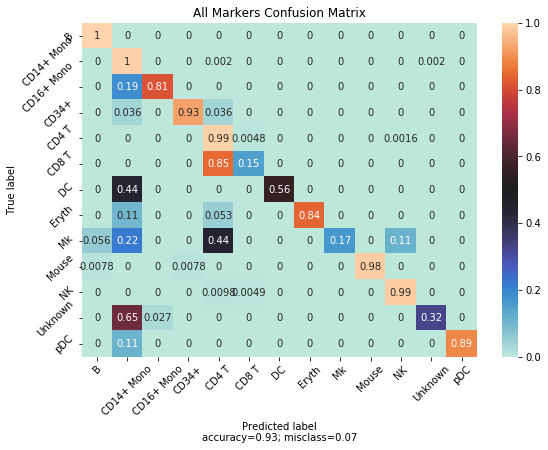

In [28]:
results =  np.load(model_save_path + 'all_markers_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'All Markers Confusion Matrix', save_path = viz_save_path + 'all_markers_cm.pdf', cmap = 'icefire')

### Smash RF

In [18]:
results =  np.load(model_save_path + 'smash_rf_results_{}.npy'.format(1), allow_pickle = True)

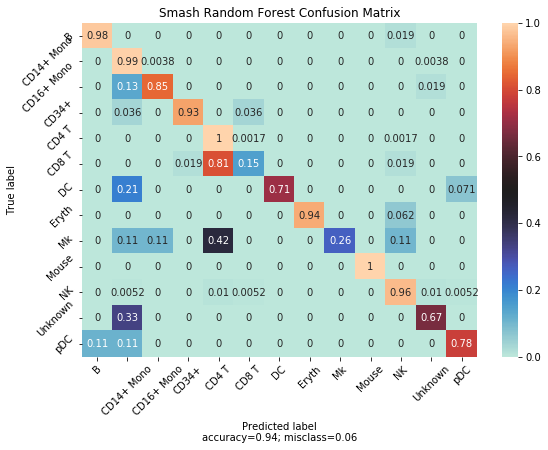

In [19]:
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash Random Forest Confusion Matrix', save_path = viz_save_path + 'smash_rf_cm.pdf', cmap = 'icefire')

### Smash DNN

In [20]:
results =  np.load(model_save_path + 'smash_results_{}.npy'.format(1), allow_pickle = True)

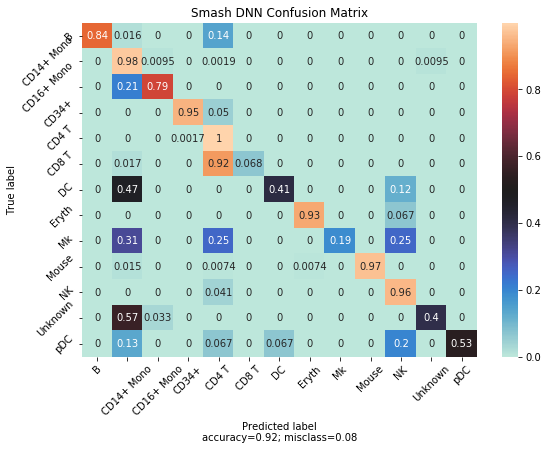

In [21]:
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash DNN Confusion Matrix', save_path = viz_save_path + 'smash_cm.pdf', cmap = 'icefire')

### RankCorr

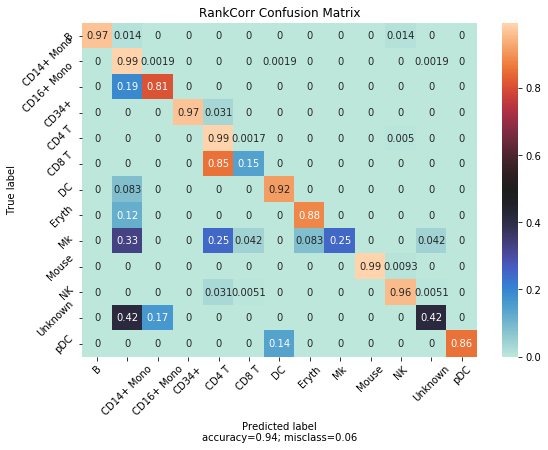

In [22]:
results =  np.load(model_save_path + 'rankcorr_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'RankCorr Confusion Matrix', save_path = viz_save_path + 'rankcorr_cm.pdf', cmap = 'icefire')

### L1 VAE

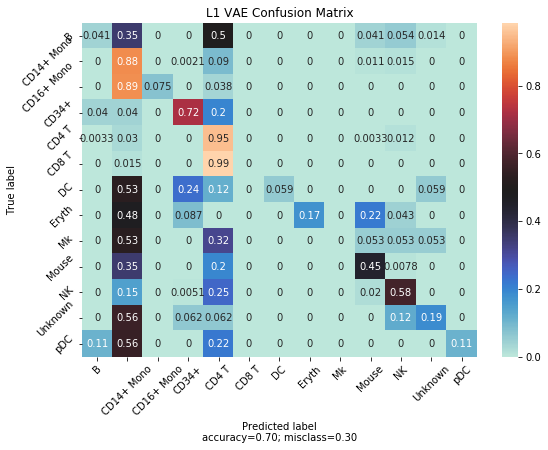

In [23]:
results =  np.load(model_save_path + 'l1_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'L1 VAE Confusion Matrix', save_path = viz_save_path + 'l1_vae_cm.pdf', cmap = 'icefire')

### Global Gate VAE

In [ ]:
results =  np.load(model_save_path + 'globalgate_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'GlobalGate VAE Confusion Matrix', save_path = viz_save_path + 'globalgate_vae_cm.pdf', cmap = 'icefire')

### Running MarkerMap Unsupervised

In [ ]:
results =  np.load(model_save_path + 'marker_map_unsupervised_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Unsupervised Confusion Matrix', save_path = viz_save_path + 'marker_map_unsupervised_cm.pdf', cmap = 'icefire')

### Running MarkerMap Supervised


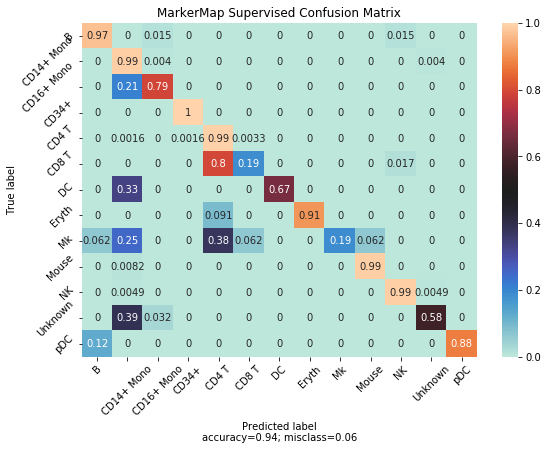

In [26]:
results =  np.load(model_save_path + 'marker_map_supervised_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Supervised Confusion Matrix', save_path = viz_save_path + 'marker_map_supervised_cm.pdf', cmap = 'icefire')

### MarkerMap Mixed Supervision

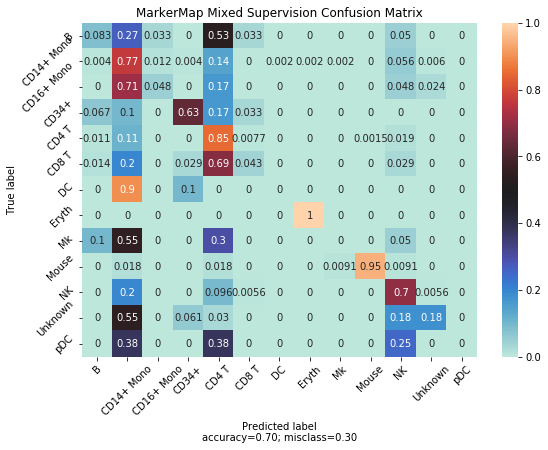

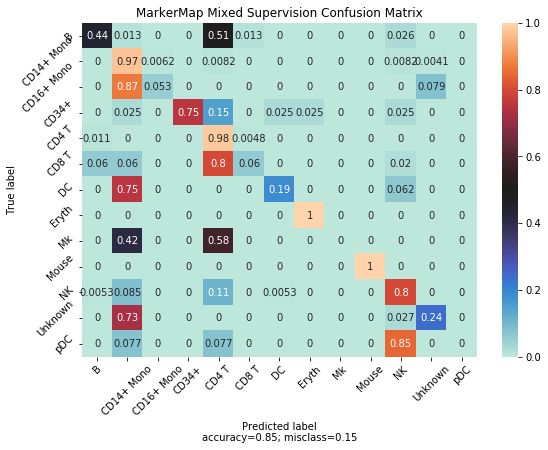

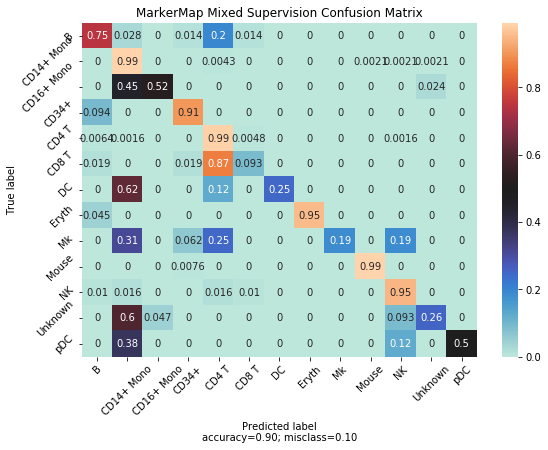

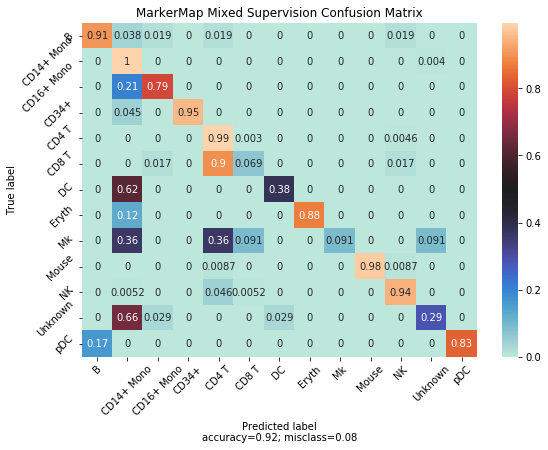

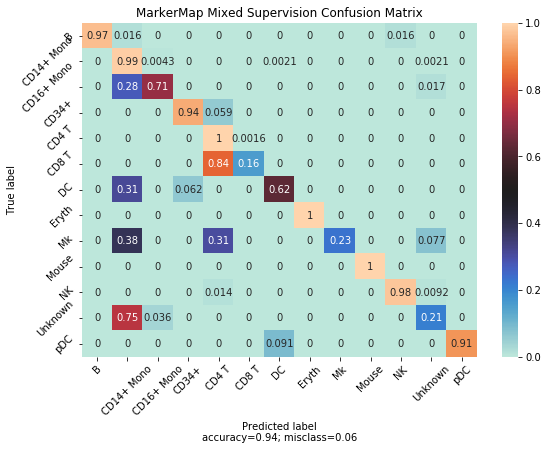

In [37]:
for k in k_range:
    results = np.load(model_save_path + 'marker_map_mixed_results_k_{}.npy'.format(k), allow_pickle=True)
    plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Mixed Supervision Confusion Matrix', save_path = viz_save_path + 'marker_map_mixed_cm.pdf', cmap = 'icefire')

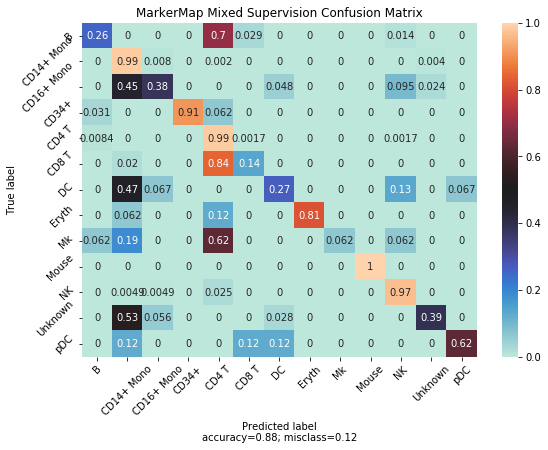

In [31]:
results =  np.load(model_save_path + 'marker_map_mixed_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Mixed Supervision Confusion Matrix', save_path = viz_save_path + 'marker_map_mixed_cm.pdf', cmap = 'icefire')

### Concrete VAE

In [ ]:
results =  np.load(model_save_path + 'concrete_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Concrete VAE Confusion Matrix', save_path = viz_save_path + 'concrete_vae_cm.pdf', cmap = 'icefire')

## LassoNet

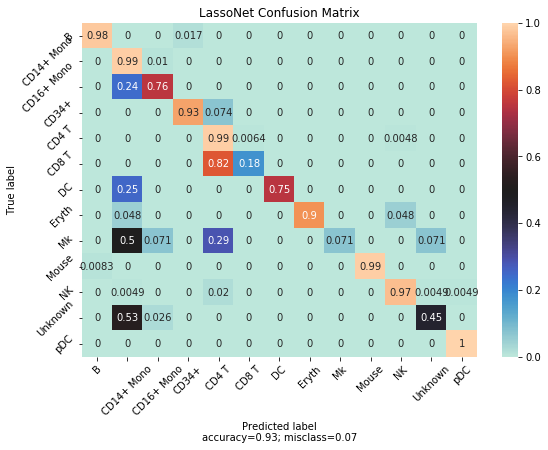

In [12]:
results =  np.load(model_save_path + 'lasso_net_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'LassoNet Confusion Matrix', save_path = viz_save_path + 'lasso_net_cm.pdf', cmap = 'icefire')

## Visualizing k on weighted f1

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (13, 6))

#rf
smash_rf_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_rf_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(rep['weighted avg']['f1-score'])


smash_dnn_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(rep['weighted avg']['f1-score'])

rank_corr_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'rankcorr_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(rep['weighted avg']['f1-score'])

l1_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'l1_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(rep['weighted avg']['f1-score'])

globalgate_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(rep['weighted avg']['f1-score'])

marker_map_unsupervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(rep['weighted avg']['f1-score'])

marker_map_supervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_supervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(rep['weighted avg']['f1-score'])


marker_map_mixed_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_mixed_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(rep['weighted avg']['f1-score'])

concrete_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(rep['weighted avg']['f1-score'])

lasso_net_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'lasso_net_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(rep['weighted avg']['f1-score'])

scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
max_point = max([max(score) for score in scores])
axs[0].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
#plt.plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[0].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[0].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
#plt.plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[0].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[0].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
#plt.plot(k_range, marker_map_mixed_scores, label = 'RunningState VAE+Classifier', color = 'blue', marker = 'o')
#plt.plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o)
axs[0].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[0].plot(k_range, max_point * np.ones(len(k_range)), linestyle = '--')
axs[0].set_xlabel("Number of Markers Selected")
axs[0].set_xticks(k_range)
axs[0].set_ylabel(r"KNN Weighted $F_1$")
axs[0].legend()

#knn

smash_rf_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_rf_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(rep['weighted avg']['f1-score'])


smash_dnn_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(rep['weighted avg']['f1-score'])

rank_corr_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'rankcorr_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(rep['weighted avg']['f1-score'])

l1_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'l1_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(rep['weighted avg']['f1-score'])

globalgate_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'globalgate_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(rep['weighted avg']['f1-score'])

marker_map_unsupervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(rep['weighted avg']['f1-score'])

marker_map_supervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_supervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(rep['weighted avg']['f1-score'])


marker_map_mixed_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_mixed_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(rep['weighted avg']['f1-score'])

concrete_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'concrete_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(rep['weighted avg']['f1-score'])

lasso_net_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'lasso_net_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(rep['weighted avg']['f1-score'])


scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
max_point = max([max(score) for score in scores])
axs[1].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
#plt.plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[1].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[1].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
#plt.plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[1].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[1].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
#plt.plot(k_range, marker_map_mixed_scores, label = 'RunningState VAE+Classifier', color = 'blue', marker = 'o')
#plt.plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o)
axs[1].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[1].plot(k_range, max_point * np.ones(len(k_range)), linestyle = '--')
axs[1].set_xlabel("Number of Markers Selected")
axs[1].set_xticks(k_range)
axs[1].set_ylabel(r"KNN Weighted $F_1$")
axs[1].legend()

plt.tight_layout()
plt.savefig(viz_save_path + 'CiteSeq_weighted_f1_vs_k.pdf')

#### Include everything

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (13, 6))

#rf
smash_rf_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_rf_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(rep['weighted avg']['f1-score'])


smash_dnn_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(rep['weighted avg']['f1-score'])

rank_corr_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'rankcorr_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(rep['weighted avg']['f1-score'])

l1_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'l1_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(rep['weighted avg']['f1-score'])

globalgate_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(rep['weighted avg']['f1-score'])

marker_map_unsupervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(rep['weighted avg']['f1-score'])

marker_map_supervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_supervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(rep['weighted avg']['f1-score'])


marker_map_mixed_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_mixed_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(rep['weighted avg']['f1-score'])

concrete_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(rep['weighted avg']['f1-score'])

lasso_net_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'lasso_net_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(rep['weighted avg']['f1-score'])

scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
max_point = max([max(score) for score in scores])
axs[0].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
axs[0].plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[0].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[0].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
axs[0].plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[0].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[0].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
axs[0].plot(k_range, marker_map_mixed_scores, label = 'MarkerMap Mixed Supervision', color = 'blue', marker = 'o')
axs[0].plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o')
axs[0].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[0].plot(k_range, max_point * np.ones(len(k_range)), linestyle = '--')
axs[0].set_xlabel("Number of Markers Selected")
axs[0].set_xticks(k_range)
axs[0].set_ylabel(r"KNN Weighted $F_1$")
axs[0].legend()

#knn

smash_rf_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_rf_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(rep['weighted avg']['f1-score'])


smash_dnn_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(rep['weighted avg']['f1-score'])

rank_corr_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'rankcorr_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(rep['weighted avg']['f1-score'])

l1_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'l1_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(rep['weighted avg']['f1-score'])

globalgate_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'globalgate_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(rep['weighted avg']['f1-score'])

marker_map_unsupervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(rep['weighted avg']['f1-score'])

marker_map_supervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_supervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(rep['weighted avg']['f1-score'])


marker_map_mixed_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_mixed_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(rep['weighted avg']['f1-score'])

concrete_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'concrete_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(rep['weighted avg']['f1-score'])

lasso_net_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'lasso_net_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(rep['weighted avg']['f1-score'])


scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
max_point = max([max(score) for score in scores])
axs[1].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
axs[1].plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[1].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[1].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
axs[1].plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[1].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[1].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
axs[1].plot(k_range, marker_map_mixed_scores, label = 'MarkerMap Mixed Supervision', color = 'blue', marker = 'o')
axs[1].plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o')
axs[1].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[1].plot(k_range, max_point * np.ones(len(k_range)), linestyle = '--')
axs[1].set_xlabel("Number of Markers Selected")
axs[1].set_xticks(k_range)
axs[1].set_ylabel(r"KNN Weighted $F_1$")
axs[1].legend()

plt.tight_layout()
plt.savefig(viz_save_path + 'CiteSeq_weighted_f1_vs_k_all.pdf')

### Do Misclassification now

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (13, 6))
# random forest
smash_rf_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_rf_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(m)

smash_dnn_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(m)

rank_corr_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'rankcorr_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(m)

l1_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'l1_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(m)

globalgate_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(m)

marker_map_unsupervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(m)

marker_map_supervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_supervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(m)

marker_map_mixed_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_mixed_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(m)

concrete_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(m)

lasso_net_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'lasso_net_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(m)
    
scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
min_point = min([min(score) for score in scores])
axs[0].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
#plt.plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[0].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[0].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
#plt.plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[0].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[0].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
#plt.plot(k_range, marker_map_mixed_scores, label = 'RunningState VAE+Classifier', color = 'blue', marker = 'o')
#plt.plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o)
axs[0].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[0].plot(k_range, min_point * np.ones(len(k_range)), linestyle = '--')
axs[0].set_xlabel("Number of Markers Selected")
axs[0].set_xticks(k_range)
axs[0].set_ylabel("RF Misclassification Rate")
axs[0].legend()

# knn
smash_rf_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_rf_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(m)

smash_dnn_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(m)

rank_corr_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'rankcorr_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(m)

l1_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'l1_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(m)

globalgate_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'globalgate_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(m)

marker_map_unsupervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(m)

marker_map_supervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_supervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(m)

marker_map_mixed_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_mixed_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(m)

concrete_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'concrete_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(m)

lasso_net_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'lasso_net_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(m)

scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
min_point = min([min(score) for score in scores])
axs[1].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
#plt.plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[1].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[1].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
#plt.plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[1].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[1].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
#plt.plot(k_range, marker_map_mixed_scores, label = 'RunningState VAE+Classifier', color = 'blue', marker = 'o')
#plt.plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o)
axs[1].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[1].plot(k_range, min_point * np.ones(len(k_range)), linestyle = '--')
axs[1].set_xlabel("Number of Markers Selected")
axs[1].set_xticks(k_range)
axs[1].set_ylabel("KNN Misclassification Rate")
axs[1].legend()

plt.tight_layout()
plt.savefig(viz_save_path + 'CiteSeq_misclassification_vs_k.pdf')

##### Include everything

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (13, 6))
# random forest
smash_rf_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_rf_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(m)

smash_dnn_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(m)

rank_corr_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'rankcorr_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(m)

l1_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'l1_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(m)

globalgate_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(m)

marker_map_unsupervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(m)

marker_map_supervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_supervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(m)

marker_map_mixed_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_mixed_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(m)

concrete_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(m)

lasso_net_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'lasso_net_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(m)
    
scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
min_point = min([min(score) for score in scores])
axs[0].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
axs[0].plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[0].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[0].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
axs[0].plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[0].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[0].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
axs[0].plot(k_range, marker_map_mixed_scores, label = 'MarkerMap Mixed Supervision', color = 'blue', marker = 'o')
axs[0].plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o')
axs[0].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[0].plot(k_range, min_point * np.ones(len(k_range)), linestyle = '--')
axs[0].set_xlabel("Number of Markers Selected")
axs[0].set_xticks(k_range)
axs[0].set_ylabel("RF Misclassification Rate")
axs[0].legend()

# knn
smash_rf_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_rf_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(m)

smash_dnn_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(m)

rank_corr_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'rankcorr_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(m)

l1_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'l1_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(m)

globalgate_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'globalgate_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(m)

marker_map_unsupervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(m)

marker_map_supervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_supervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(m)

marker_map_mixed_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_mixed_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(m)

concrete_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'concrete_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(m)

lasso_net_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'lasso_net_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(m)

scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
min_point = min([min(score) for score in scores])
axs[1].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
axs[1].plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[1].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[1].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
axs[1].plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[1].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[1].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
axs[1].plot(k_range, marker_map_mixed_scores, label = 'MarkerMap Mixed Supervision', color = 'blue', marker = 'o')
axs[1].plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o')
axs[1].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[1].plot(k_range, min_point * np.ones(len(k_range)), linestyle = '--')
axs[1].set_xlabel("Number of Markers Selected")
axs[1].set_xticks(k_range)
axs[1].set_ylabel("KNN Misclassification Rate")
axs[1].legend()

plt.tight_layout()
plt.savefig(viz_save_path + 'CiteSeq_misclassification_vs_k_all.pdf')

## Visualize Marker Selection

### Smash RF

In [ ]:
smash_rf_markers = {}
smash_rf_f1 = {}

In [ ]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/smash_rf_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'smash_rf_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'smash_rf_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    smash_rf_markers[k] = marker_data
    smash_rf_f1[k] = weighted_f1_score

### Smash DNN

In [ ]:
smash_dnn_markers = {}
smash_dnn_f1 = {}

In [ ]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/smash_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'smash_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'smash_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    smash_dnn_markers[k] = marker_data
    smash_dnn_f1[k] = weighted_f1_score

### RankCorr

In [ ]:
rankcorr_markers ={}
rankcorr_f1 = {}

In [ ]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/rankcorr_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'rankcorr_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'rankcorr_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    rankcorr_markers[k] = marker_data
    rankcorr_f1[k] = weighted_f1_score

### L1 VAE

In [ ]:
l1_vae_markers = {}
l1_vae_f1 = {}

In [ ]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/l1_vae_indices_k_{}.npy'.format(k), allow_pickle = True)
    X_train = X[train_indices, :]
    feature_std = np.apply_along_axis(np.std, 0, X_train)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'l1_vae_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']

    model = load_model(VAE_l1_diag, model_save_path + 'l1_vae_k_{}.ckpt'.format(k))
    with torch.no_grad():
        markers = model.markers(feature_std, k)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    l1_vae_markers[k] = marker_data
    l1_vae_f1[k] = weighted_f1_score

### GlobalGate VAE

In [ ]:
globalgate_vae_markers = {}
globalgate_vae_f1 = {}

In [ ]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/globalgate_vae_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'globalgate_vae_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    globalgate_vae_markers[k] = marker_data
    globalgate_vae_f1[k] = weighted_f1_score

### MarkerMap Unsupervised

In [ ]:
marker_map_unsupervised_markers = {}
marker_map_unsupervised_f1 = {}

In [ ]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'marker_map_unsupervised_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'marker_map_unsupervised_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    marker_map_unsupervised_markers[k] = marker_data
    marker_map_unsupervised_f1[k] = weighted_f1_score

### RunningState Classifier

In [ ]:
marker_map_supervised_markers = {}
marker_map_supervised_f1 = {}

In [ ]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'marker_map_supervised_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'marker_map_supervised_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    marker_map_supervised_markers[k] = marker_data
    marker_map_supervised_f1[k] = weighted_f1_score

### MarkerMap Mixed Supervision

In [33]:
marker_map_mixed_markers = {}
marker_map_mixed_f1 = {}

In [34]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/marker_map_mixed_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'marker_map_mixed_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'marker_map_mixed_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    marker_map_mixed_markers[k] = marker_data
    marker_map_mixed_f1[k] = weighted_f1_score

In [36]:
marker_map_mixed_f1

{10: 0.6683578311206233,
 25: 0.8139669554089486,
 50: 0.8767806650290385,
 100: 0.903009541029053,
 250: 0.9250506236865625}

### Concrete VAE

In [ ]:
concrete_vae_markers = {}
concrete_vae_f1 = {}

In [ ]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/concrete_vae_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'concrete_vae_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    concrete_vae_markers[k] = marker_data
    concrete_vae_f1[k] = weighted_f1_score

## LassoNet

In [13]:
lasso_net_markers = {}
lasso_net_f1 = {}

In [14]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/lasso_net_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'lasso_net_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'lasso_net_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    lasso_net_markers[k] = marker_data
    lasso_net_f1[k] = weighted_f1_score

FileNotFoundError: ignored

### The Actual Subplot

In [ ]:
def plot_row(ax, name, k_range, markers, f1):
    assert len(ax) == len(k_range)
    for i in range(len(k_range)):
        col = ax[i]
        k = k_range[i]
        if i == 0:
            col.set_ylabel("{}".format(name))
        col.set_ylim([0, 1.2])
        col.set_yticks([0, 1.0])
        col.set_title("{} Markers(Weighted F1 {:.3g})".format(k, f1[k]))        
        col.bar(range(X.shape[1]), markers[k], width = 10)
    return

In [ ]:
fig, axs = plt.subplots(nrows=10, ncols = len(k_range), figsize = (20, 15))

plot_row(axs[0], 'Smash RF', k_range, smash_rf_markers, smash_rf_f1)
plot_row(axs[1], 'Smash DNN', k_range, smash_dnn_markers, smash_dnn_f1)
plot_row(axs[2], 'RankCorr', k_range, rankcorr_markers, rankcorr_f1)
plot_row(axs[3], 'L1 VAE', k_range, l1_vae_markers, l1_vae_f1)
plot_row(axs[4], 'GlobalGate VAE', k_range, globalgate_vae_markers, globalgate_vae_f1)
plot_row(axs[5], 'MarkerMap Unsupervised', k_range, marker_map_unsupervised_markers, marker_map_unsupervised_f1)
plot_row(axs[6], 'MarkerMap Supervised', k_range, marker_map_supervised_markers, marker_map_supervised_f1)
plot_row(axs[7], 'MarkerMap Mixed Supervision', k_range, marker_map_mixed_markers, marker_map_mixed_f1)
plot_row(axs[8], 'ConcreteVAE', k_range, concrete_vae_markers, concrete_vae_f1)
plot_row(axs[9], 'LassoNet', k_range, lasso_net_markers, lasso_net_f1)


plt.tight_layout()
plt.savefig(viz_save_path + 'CiteSeq_SelectedMarkers_All_Methods_ks.png')
plt.show()

In [ ]:
plt.close('all')